In [1]:
from __future__ import print_function, division

# We'll need numpy for some mathematical operations
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.style as ms
import soundfile as sf
import scipy.signal as scipy

ms.use('seaborn-muted')
%matplotlib inline

# and IPython.display for audio output
import IPython.display

# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display
import time
from scipy.signal import find_peaks, peak_prominences
import pywt

In [2]:

# Pre-Define Internal Functions:

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipy.butter(order, [low, high], btype='band')
    return (b, a)



def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = scipy.filtfilt(b, a, data)
    return y


def tempdir_create(tempdir_path):
    if not os.path.exists(tempdir_path):
            os.mkdir(tempdir_path)
            print("Directory " , tempdir_path ,  " Created ")
    else:    
            print("Directory " , tempdir_path ,  " already exists")

            
def spec_plot(f, Pxx_den, peaks_sp, audio_path):
    
    plt.figure(figsize=(18, 6))
    plt.semilogy(f, Pxx_den)
    plt.ylim([1e-7, 1e1])
    plt.xlim([0,4000])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.title(spec_plot)
    plt.plot(f[peaks_sp], Pxx_den[peaks_sp], "ro")

    plt.savefig(os.path.join(outdir, spec_plot), bbox_inches='tight')


def rle(inarray, rmsframe):
    """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
    ia = np.asarray(inarray)                  # force numpy
    n = len(ia)
    if n == 0: 
        return (None, None, None)
    else:
        y = np.array(ia[1:] != ia[:-1])     # pairwise unequal (string safe)
        i = np.append(np.where(y), n - 1)   # must include last element posi
        z = np.diff(np.append(-1, i))       # run lengths
        p = np.cumsum(np.append(0, z))[:-1] # positions
        f = p+z #end position
        st = rmsframe[p]#actual start position
        ed = rmsframe[f-1]
        tst = st/44100
        ted = ed/44100
        
        return (z, p, f, ia[i], st, ed, tst, ted)   

    
def callpulse(row):
    starting=np.array(row['fstart'])
    if((starting-441)<0):
        starting=0
    else:
        starting=starting-441
        starting=starting.astype(int)
        
    
    ending=np.array(row['fend'])
    if((ending+441)<len(xf)):
        ending=ending+441
    ending=ending.astype(int)
    
    
    
    lowcut=max(peaks_sp)-100
    highcut=max(peaks_sp)+150

    xfp = butter_bandpass_filter(signal_p[starting:ending], lowcut, highcut, Fs, order=4)
    
        
    coef, freqs = pywt.cwt(xfp, np.arange(1,5), 'mexh')
    coef_df = pd.DataFrame(coef)

    # Step 2: Smooth the Wavelet Transformation
    test = scipy.savgol_filter(np.abs(coef_df.mean(axis=0)), 433, 3)
    test = scipy.savgol_filter(test, 251, 3)


    peaks, _ = find_peaks(test, distance=50, prominence = .002, rel_height= 20, width = 20)
    #peaks = ','.join(map(str, peaks))
    
    
    if(len(peaks)>0):
        return peaks+starting


def parallelize(data, func, num_of_processes=8):
    data_split = np.array_split(data, num_of_processes)
    pool = Pool(num_of_processes)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    
    return data



def run_on_subset(func, data_subset):
    return data_subset.apply(func, axis=1)



def parallelize_on_rows(data, func, num_of_processes=8):
    return parallelize(data, partial(run_on_subset, func), num_of_processes)



In [ ]:
def write_split_script(audio_path):
    bash_script = '''#!/bin/bash

#INPUTS

AFILE='{out_dir}/{audio_path}' # Put the path to the file i.e. /Desktop/20190222_Xlaevis....
OUTDIR='{out_dir}' # Where you want the files to be exported i.e. /Desktop/

##1. Calculate the duration of the audio file:

mkdir $OUTDIR/{NAME}/ # Creates the directory with your AFILE name

DUR=$(ffprobe -i $AFILE -show_format -v quiet | sed -n 's/duration=//p') # the complete duration of the file
echo $DUR 
RDUR=$(echo $DUR | awk '{{print$0+(n-$0%n)%n}}' n={time}) 

echo "Rounding to the nearest hour: $RDUR"
N_files=$(($RDUR/{time})) 



##2. Generate Chunks of .WAV files:
echo "Splitting $NAME into $N_files Files"

mkdir $OUTDIR/{NAME}/mono_wav_left
mkdir $OUTDIR/{NAME}/mono_wav_right

N='0'
#CHUNK="$(($N_files))"
CHUNK=6

while [ "$N" -lt $CHUNK ] ; do
	O_AFILE=$(echo "$OUTDIR/{NAME}_chunk${{N}}_startt$(($N*{time}+{acc})).flac")
	echo $O_AFILE
	N_sec=$(($N*{time}+{acc}))
    echo $N_sec
	ffmpeg -hide_banner -loglevel panic -ss $N_sec -i $AFILE -acodec copy -t {time} $O_AFILE
	

	C_file_Lout=$(echo "$OUTDIR/{NAME}_chunk${{N}}_startt$(($N* {time}+{acc}))_monoleft.flac")
	C_file_Rout=$(echo "$OUTDIR/{NAME}_chunk${{N}}_startt$(($N* {time}+{acc}))_monoright.flac")
	ffmpeg -hide_banner -loglevel panic -i $O_AFILE -map_channel 0.0.0 $C_file_Lout -map_channel 0.0.1 $C_file_Rout

	
	LNAME=$(echo {NAME})
	echo $LNAME
	W_file_Lout=$(echo "$OUTDIR/{NAME}/mono_wav_left/${{LNAME}}_chunk${{N}}_startt$(($N*{time}+{acc}))_monoleft.wav")
	ffmpeg -hide_banner -loglevel panic -i $C_file_Lout $W_file_Lout
	
	RNAME=$(echo {NAME})
	echo $RNAME
	W_file_Rout=$(echo "$OUTDIR/{NAME}/mono_wav_right/${{RNAME}}_chunk${{N}}_startt$(($N*{time}+{acc}))_monoright.wav")
	ffmpeg -hide_banner -loglevel panic -i $C_file_Rout $W_file_Rout


	let "N = N + 1"
done


##3. Convert each file to WAV
	#mkdir $OUTDIR/{NAME}/chunks
	#mv $OUTDIR/$(echo "{NAME}_chunk")*.flac $OUTDIR/{NAME}/chunks/
	rm $OUTDIR/*{NAME}_chunk*.flac
    rm $O_AFILE
    rm $C_file_Lout
    rm $C_file_Rout


##5. Completion:
	echo "Complete Split!"
 	echo "Moving to Second Hand Annotation"
    
    

##6. Run python script on all files in the outdir
#    mkdir $OUTDIR/{NAME}/mono_wav_left/segments
#    python Frog_segmenter_v14.py $OUTDIR/{NAME}/mono_wav_left $OUTDIR/{NAME}/mono_wav_left/segments 44100


'''.format(time=7200, acc=600, audio_path = audio_path, out_dir=directory, NAME = NAME)

    return bash_script

In [ ]:
import os

directory='/Volumes/Kelley_lab/Recording_test_st/Laevis/Flac/'

for audio_path in os.listdir(directory):
    if audio_path.endswith(".flac"):
        bash_file = os.path.join(directory, os.path.splitext(audio_path)[0]+'_split.bash')
        print(bash_file)
        NAME=os.path.splitext(audio_path)[0]
        bash_script = write_split_script(audio_path)
    
        with open(bash_file, "w") as text_file:
            text_file.write(bash_script)
            
        

R_F8247_chunk4_startt29400_monoright copy.wav
done
R_F8247_chunk4_startt29400_monoright.wav
done
R_F8247_chunk5_startt36600_monoright copy.wav
done
R_F8247_chunk5_startt36600_monoright.wav
done
R_F815A_chunk4_startt29400_monoright copy.wav
done
R_F815A_chunk4_startt29400_monoright.wav
done
R_F815A_chunk5_startt36600_monoright copy.wav
done
R_F815A_chunk5_startt36600_monoright.wav
done
R_F820F_chunk4_startt29400_monoright.wav
done
R_F821F_chunk0_startt600_monoright.wav
done
R_F813E_chunk0_startt600_monoright.wav
done
R_F813E_chunk1_startt7800_monoright copy.wav
done
R_F813E_chunk1_startt7800_monoright.wav
done
R_F81F4_chunk4_startt29400_monoright copy.wav
done
R_F8203_chunk2_startt15000_monoright copy.wav
done
R_F821F_chunk10_startt72600_monoright.wav
done
R_F821F_chunk3_startt22200_monoright.wav
done
R_F821F_chunk9_startt65400_monoright.wav
done
R_F8180_chunk3_startt22200_monoright.wav
done
R_F8180_chunk4_startt29400_monoright.wav
done
R_F8180_chunk5_startt36600_monoright.wav
done
R_F8

1
20190504_L_F8160_Mic2_chunk2_startt15000_monoleft.wav
done
20190504_L_F8160_Mic2_chunk3_startt22200_monoleft copy.wav
1
20190516A_L-F81CD_hyd2_R-F81F8_chunk1_startt7800_monoleft.wav
1
20190516A_L-F81CD_hyd2_R-F81F8_chunk2_startt15000_monoleft.wav
1
20190516A_L-F81CD_hyd2_R-F81F8_chunk3_startt22200_monoleft.wav
1
20190516A_L-F81CD_hyd2_R-F81F8_chunk4_startt29400_monoleft.wav
1
20190515_L-F81CD_hyd2_R-F81F8_chunk3_startt22200_monoleft.wav
1
20190515_L-F81CD_hyd2_R-F81F8_chunk4_startt29400_monoleft.wav
1
20190515_L-F81CD_hyd2_R-F81F8_chunk5_startt36600_monoleft.wav
done
20190515_L-F81DD_hyd2_R-F81B8_chunk0_startt600_monoleft.wav
done
20190613_L_F81F6_hyd5_chunk1_startt7800_monoleft.wav
done
20190613_L_F81F6_hyd5_chunk2_startt15000_monoleft.wav
done
20190612_L_F81C5_hyd5_chunk2_startt15000_monoleft.wav
done
20190612_L_F81C5_hyd5_chunk3_startt22200_monoleft.wav
done
20190611_L_F8224_hyd5_chunk1_startt7800_monoleft.wav
1
20190611_L_F8224_hyd5_chunk2_startt15000_monoleft.wav
1
20190611_L_F8

/Users/labby/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


20190617_L_F81E8_hyd5_chunk2_startt15000_monoleft.wav
3
20190617_L_F81E8_hyd5_chunk3_startt22200_monoleft.wav
1
20190617_L_F81E8_hyd5_chunk4_startt29400_monoleft.wav
3
20190616_L_F81EE_hyd5_chunk2_startt15000_monoleft.wav
3
20190616_L_F81EE_hyd5_chunk3_startt22200_monoleft.wav
3
20190616_L_F81EE_hyd5_chunk4_startt29400_monoleft.wav
3
20190616_L_F81EE_hyd5_chunk5_startt36600_monoleft.wav
3
20190616_L_F81EE_hyd5_chunk6_startt43800_monoleft.wav
3
20190616_L_F81EE_hyd5_chunk7_startt51000_monoleft.wav
3
20190611_L_F8200_hyd5_chunk4_startt29400_monoleft.wav
12
20190611_L_F8224_hyd5_chunk0_startt600_monoleft.wav
7
20190611_L_F8224_hyd5_chunk5_startt36600_monoleft.wav
1
20190612A_L_F8200_hyd5_R_F81AB_hyd3_Lexi2_chunk2_startt15000_monoleft.wav
done
20190612A_L_F8200_hyd5_R_F81AB_hyd3_Lexi2_chunk3_startt22200_monoleft.wav
done
20190612A_L_F8200_hyd5_R_F81AB_hyd3_Lexi2_chunk4_startt29400_monoleft.wav
done
20190612A_L_F8200_hyd5_R_F81AB_hyd3_Lexi2_chunk5_startt36600_monoleft.wav
done
20190612_L-F8

IOError: [Errno 2] No such file or directory: '/Volumes/Kelley_lab/Wave_files/20190428_L_F8193_Mic2_chunk2_startt15000_monoleft_calls.txt'

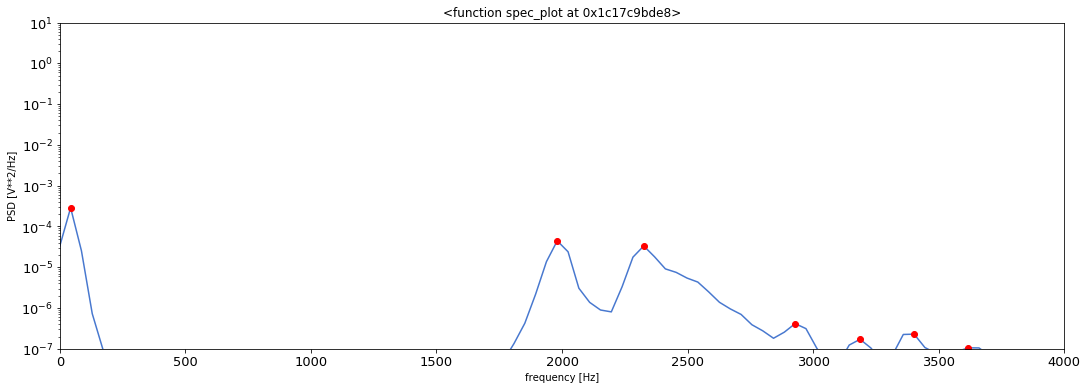

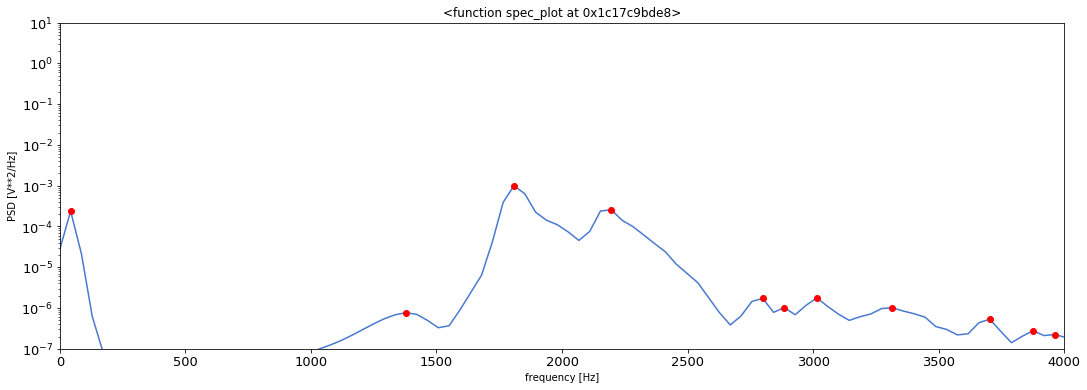

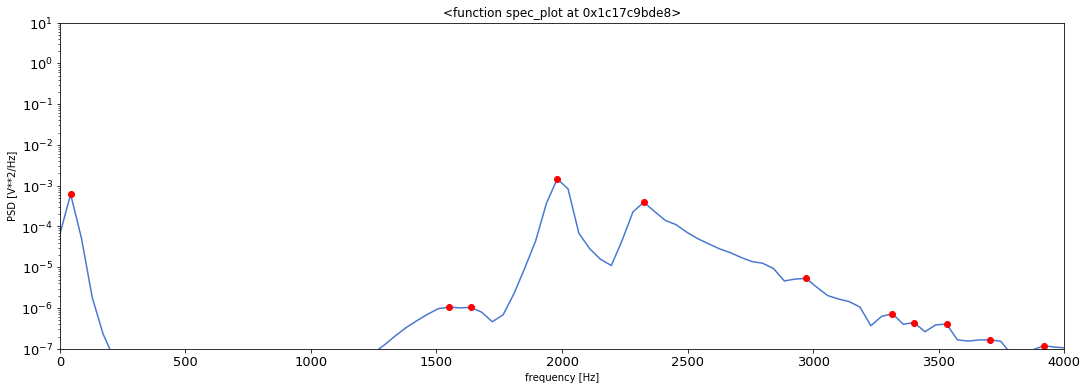

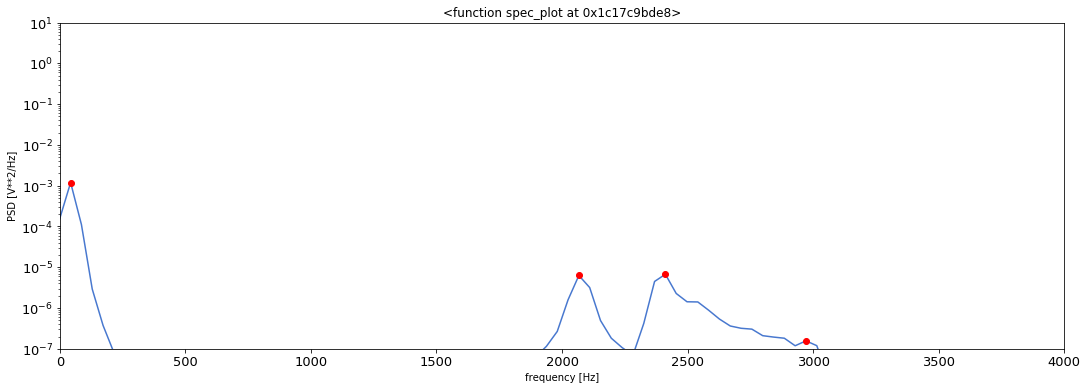

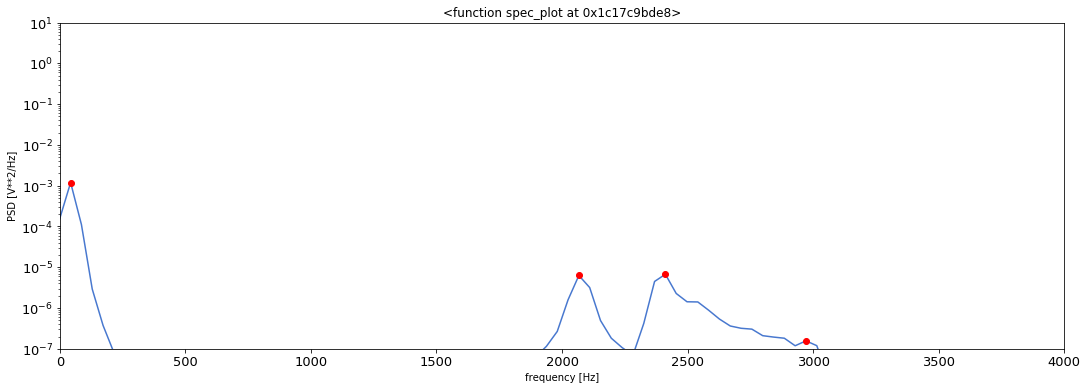

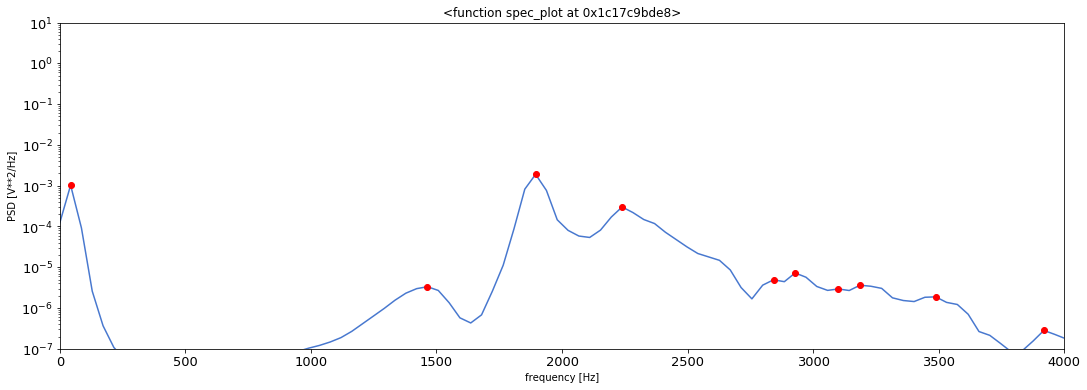

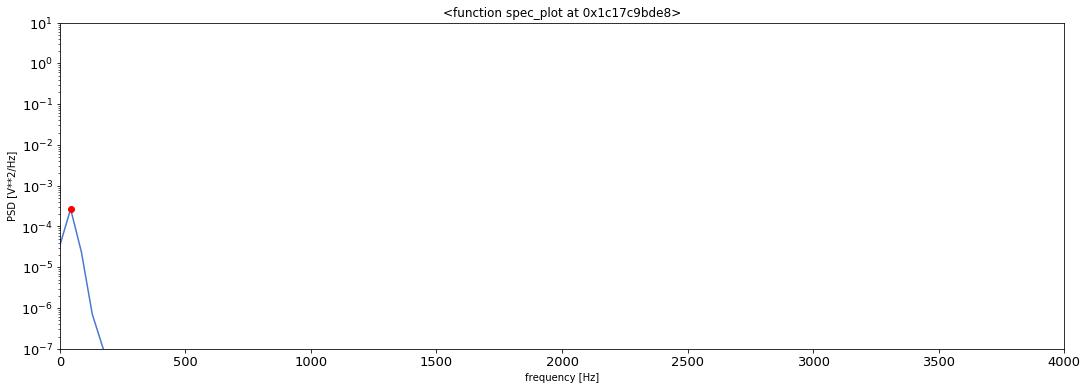

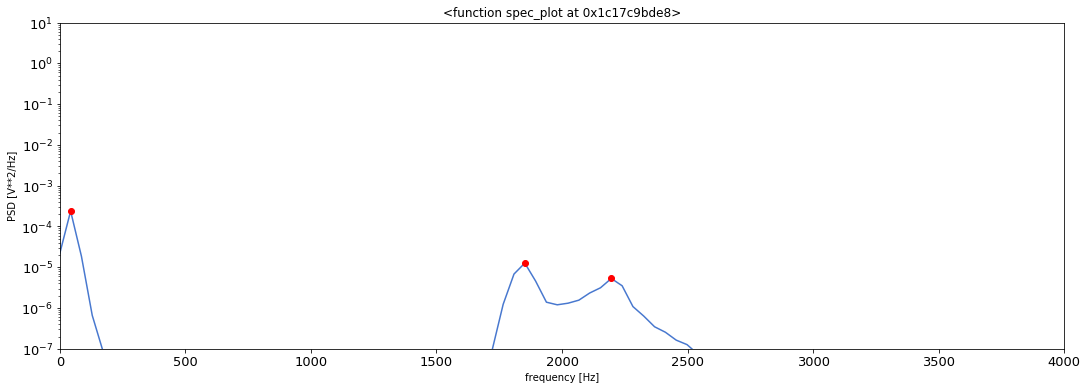

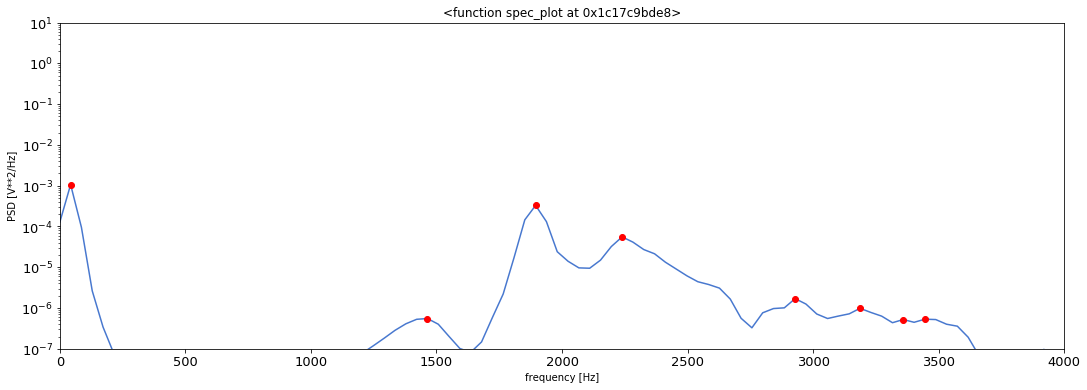

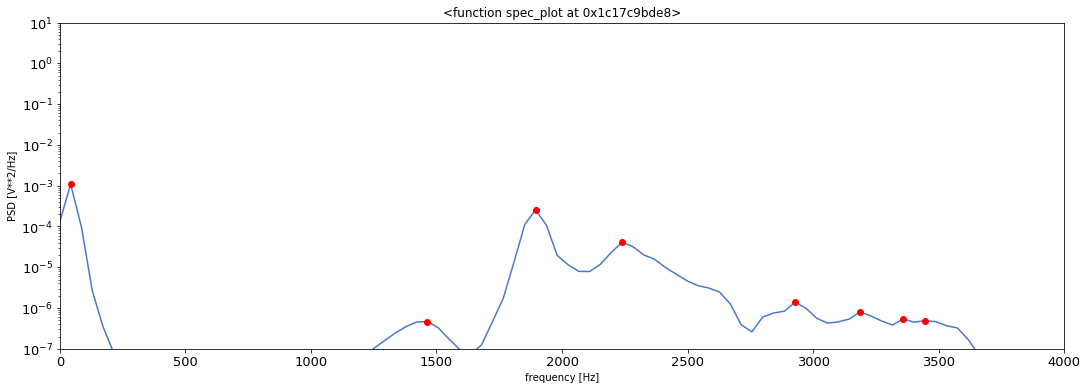

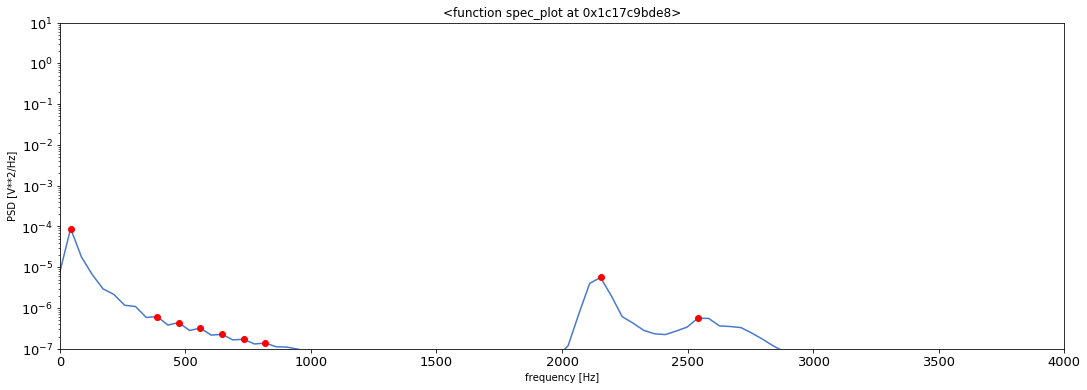

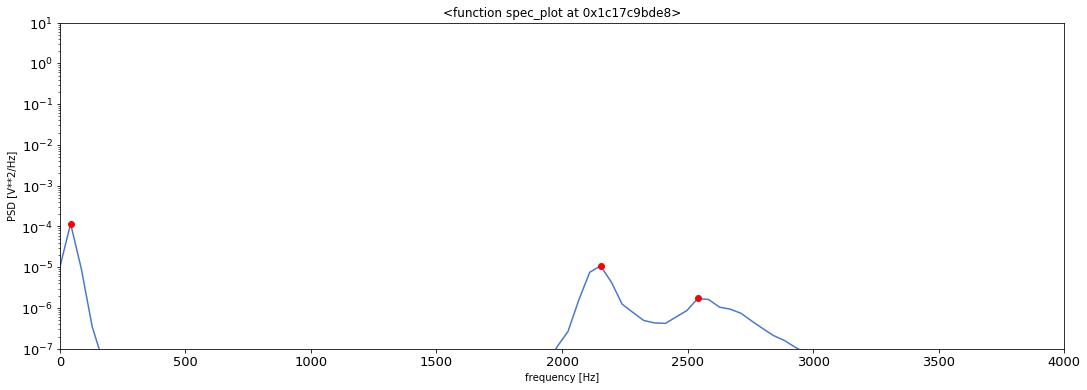

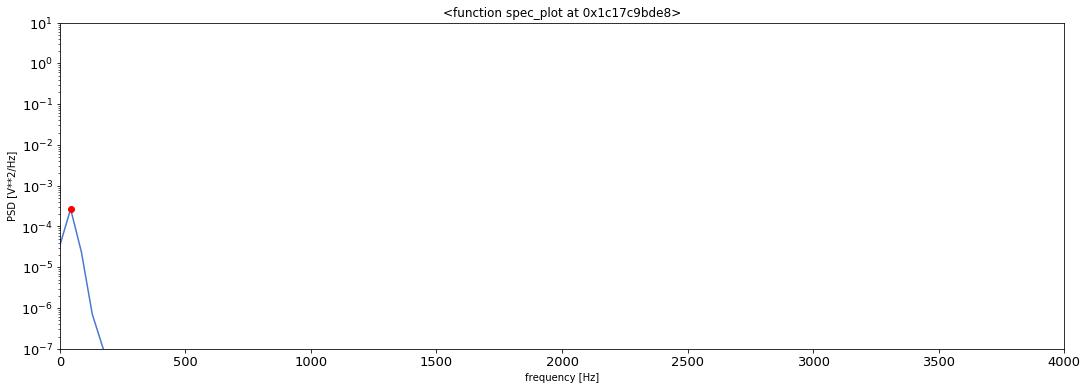

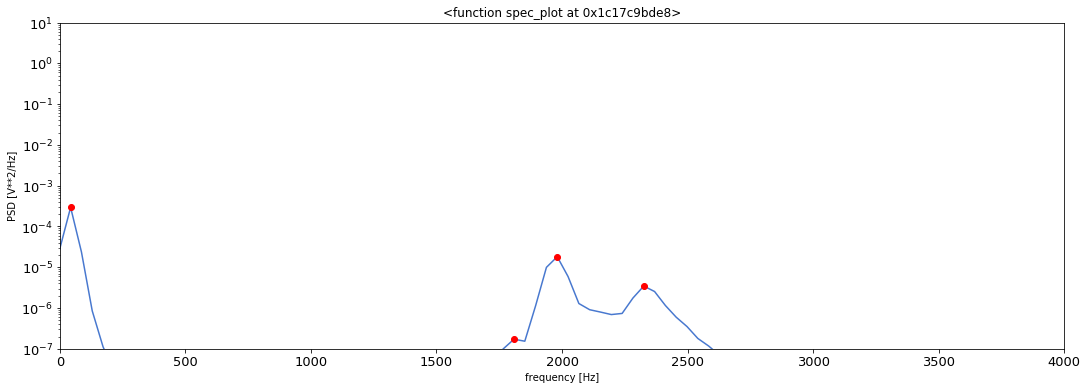

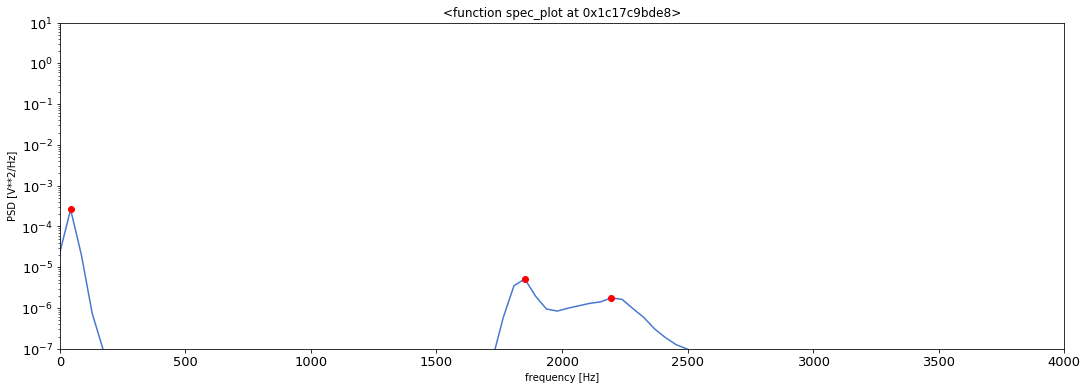

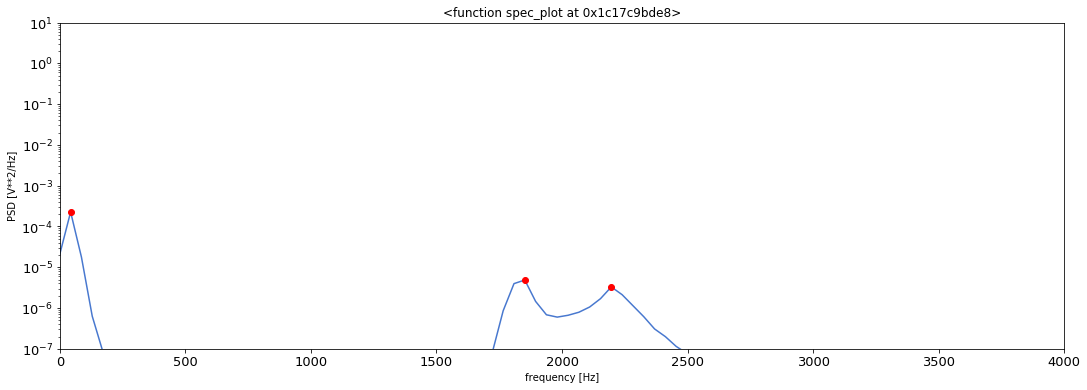

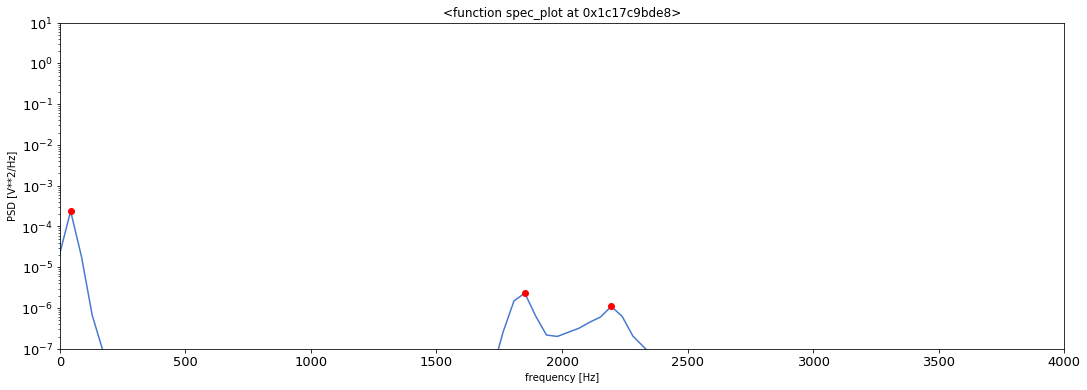

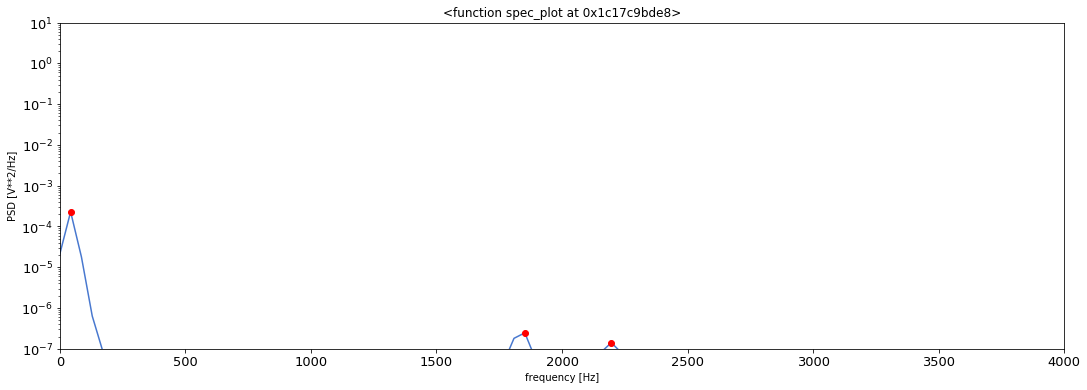

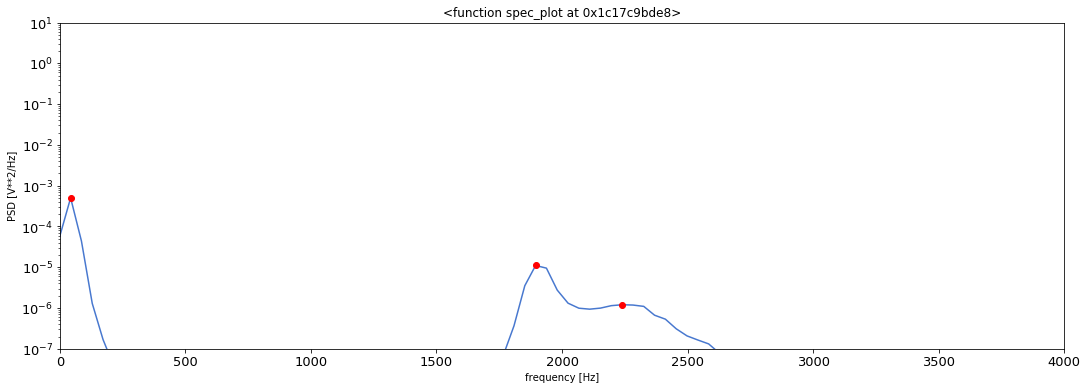

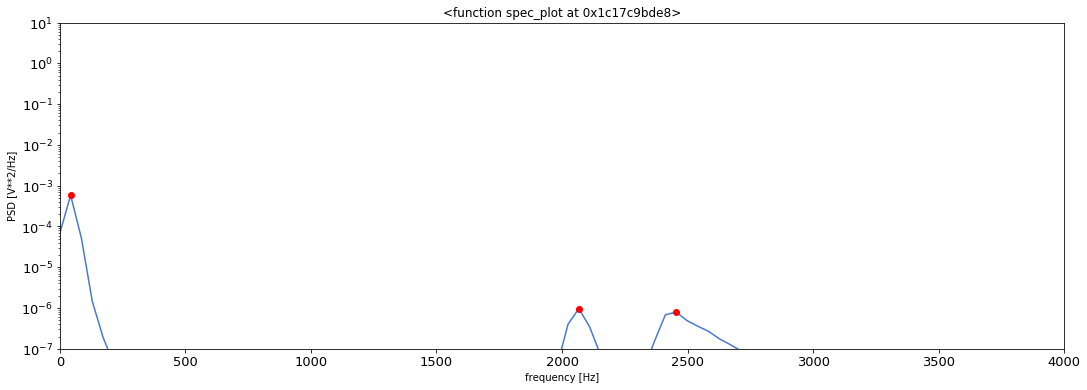

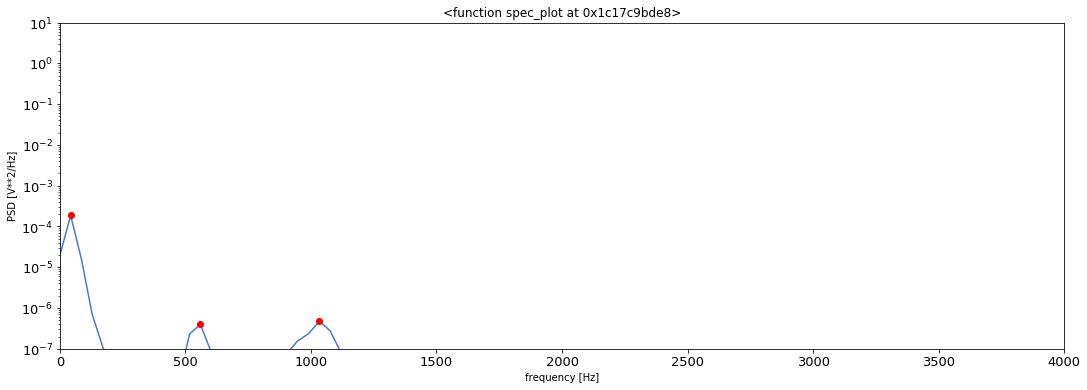

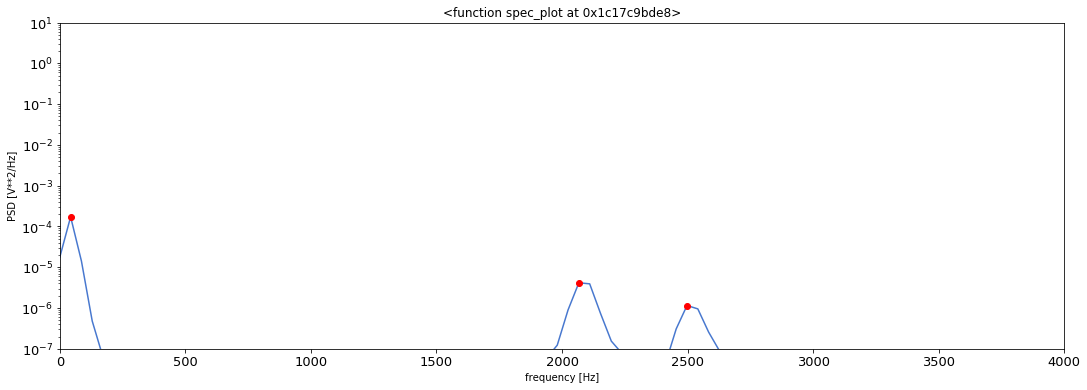

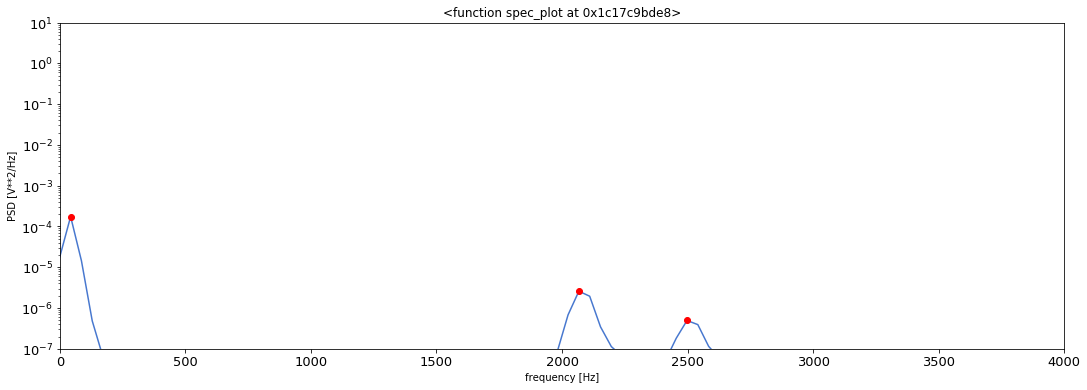

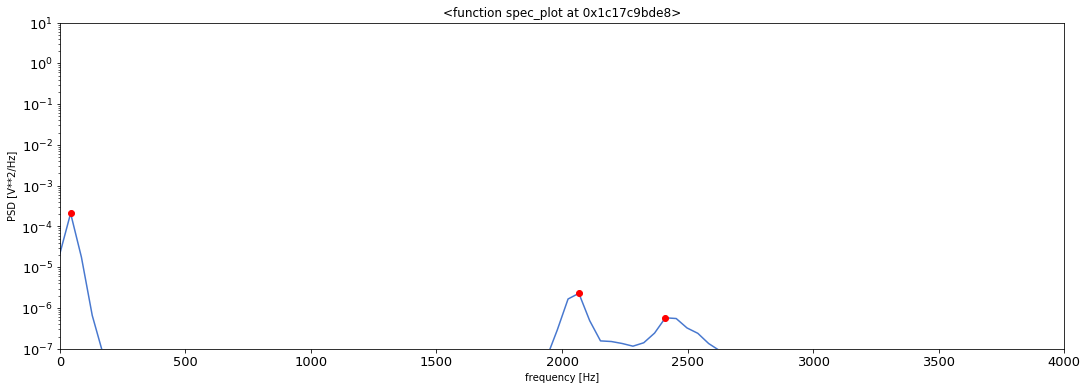

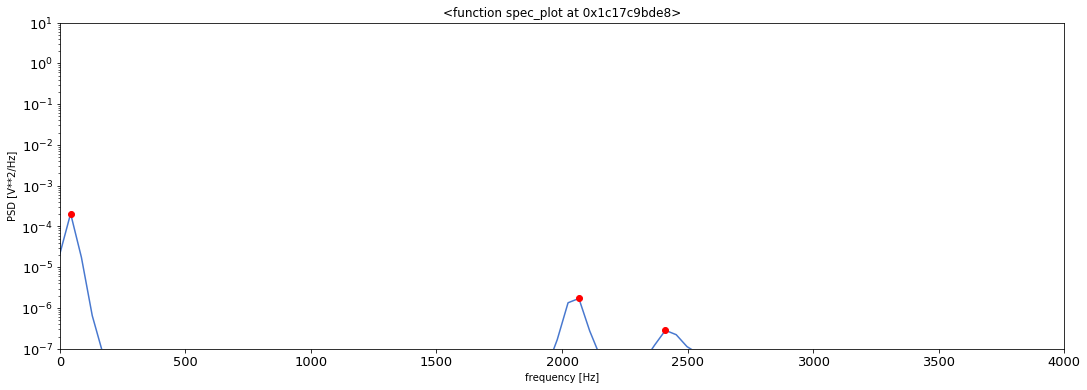

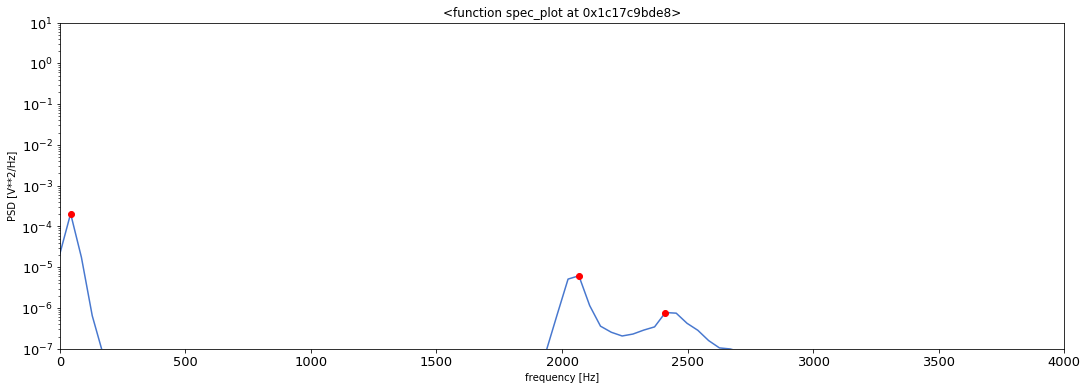

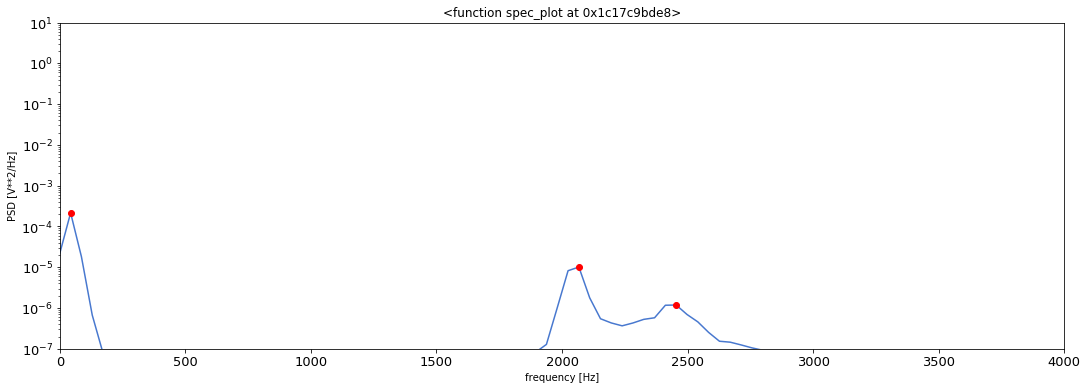

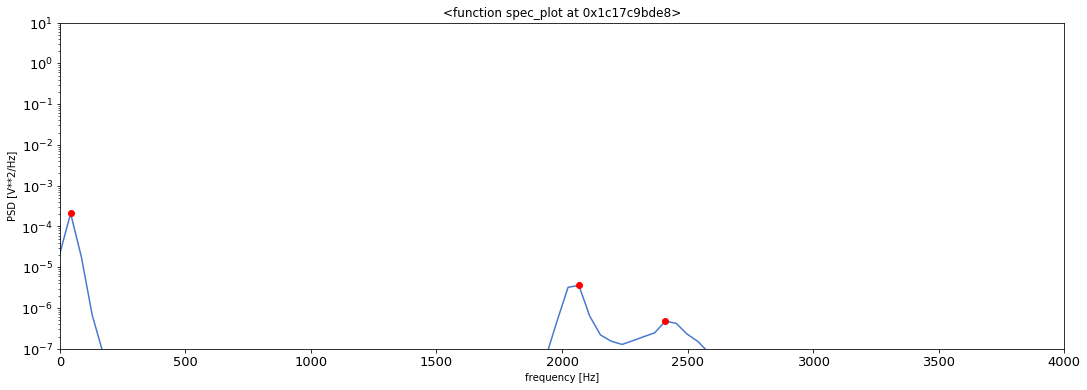

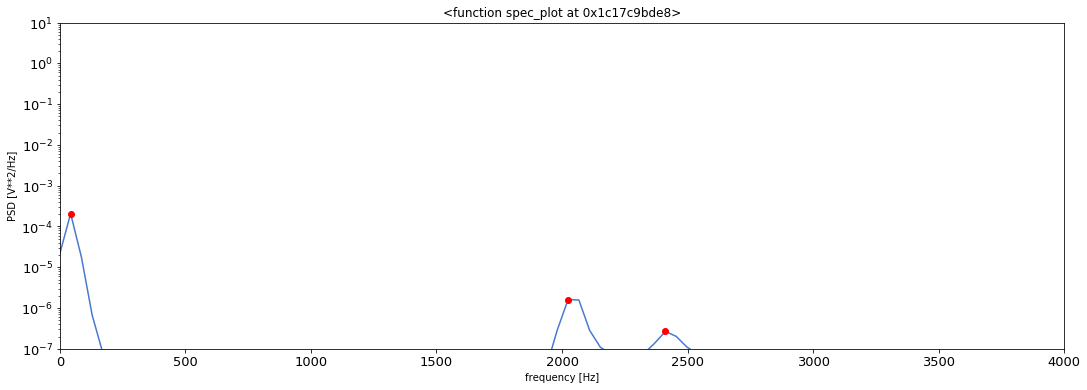

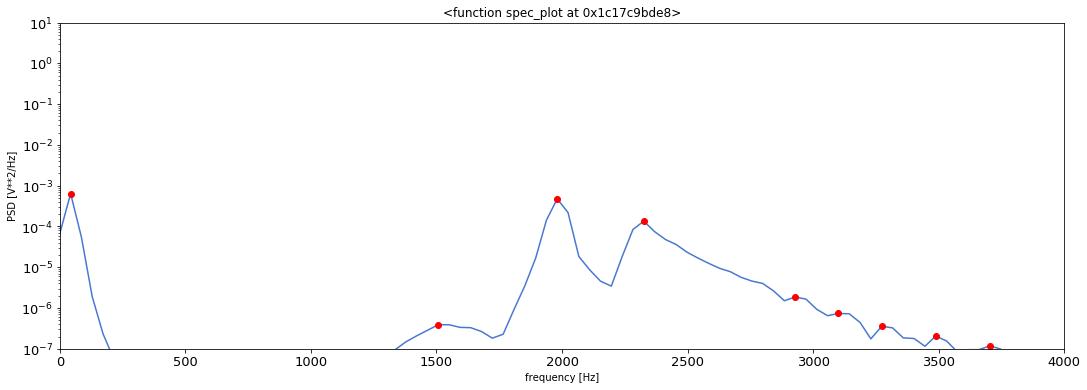

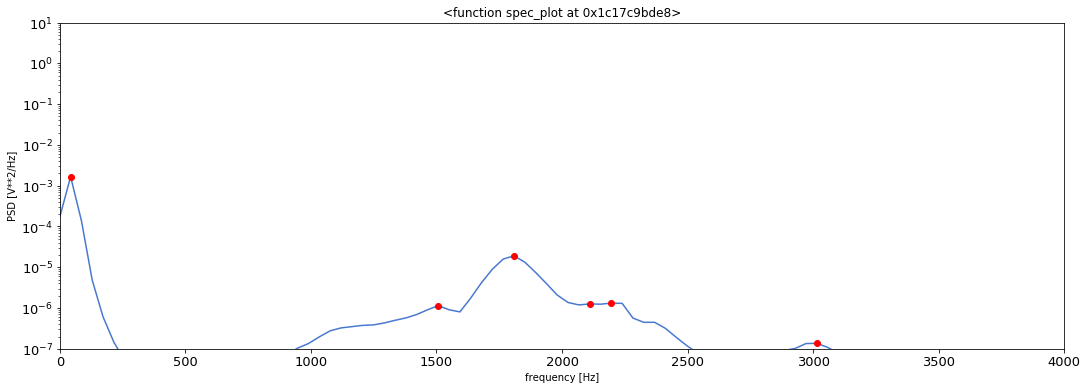

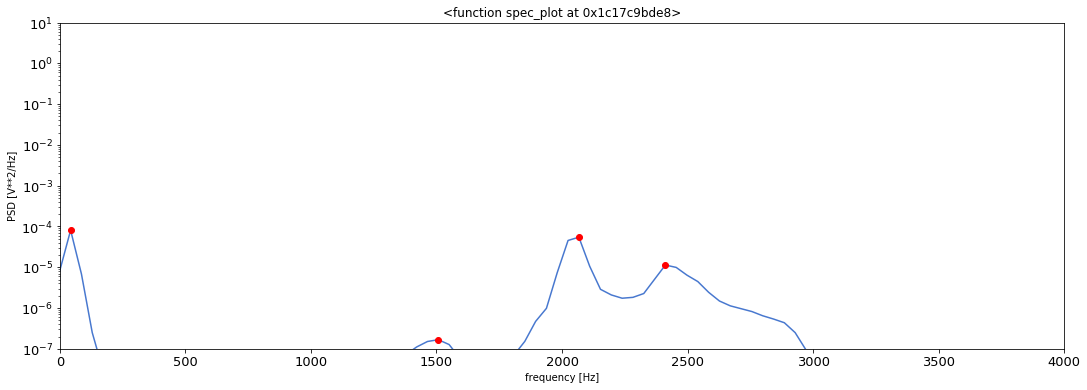

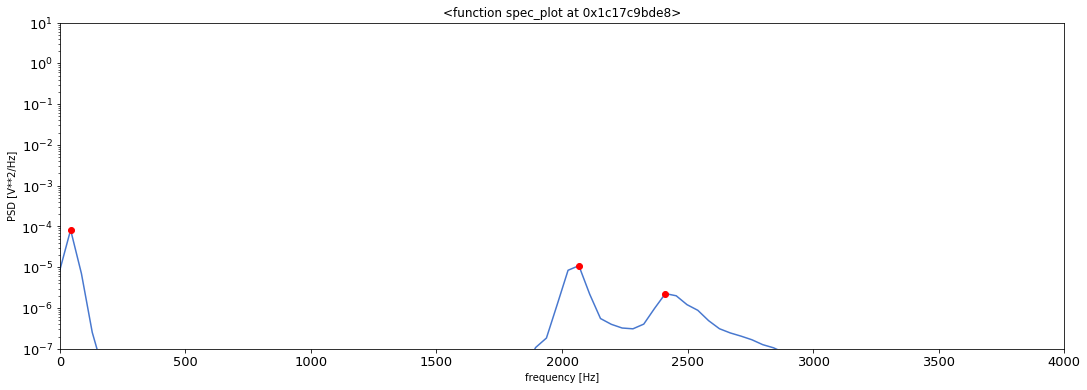

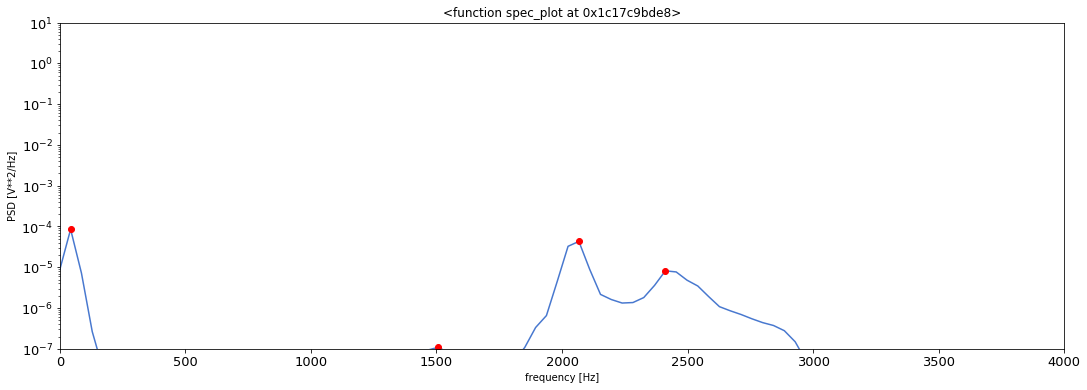

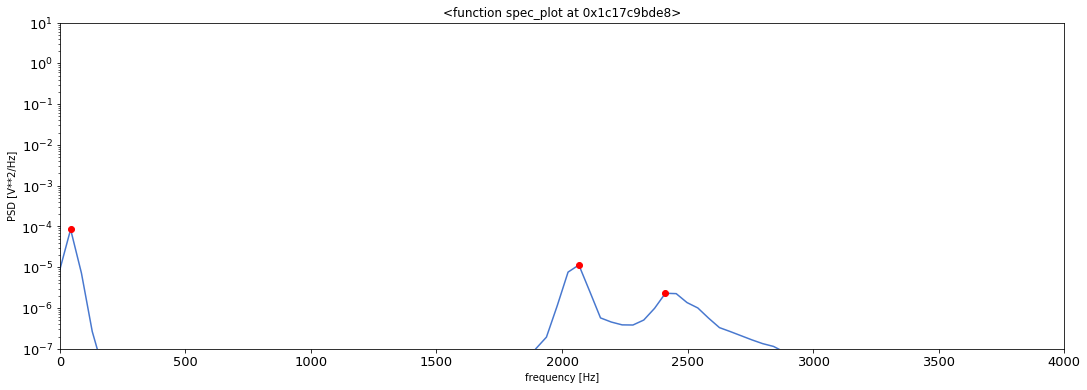

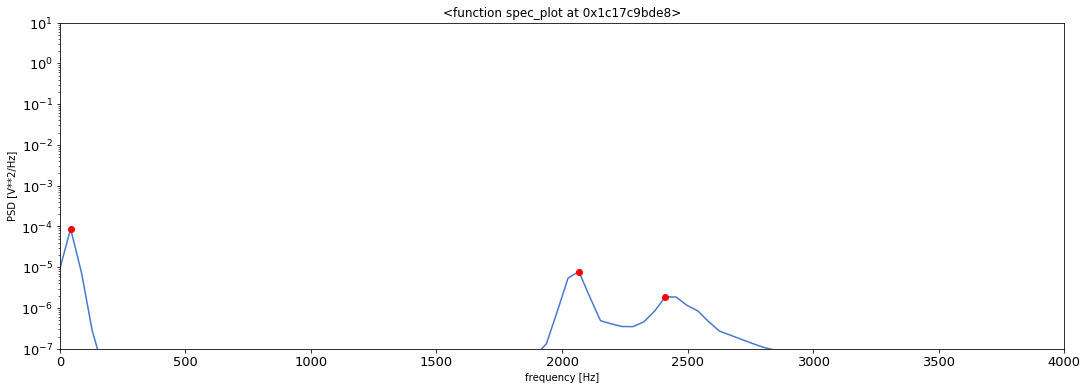

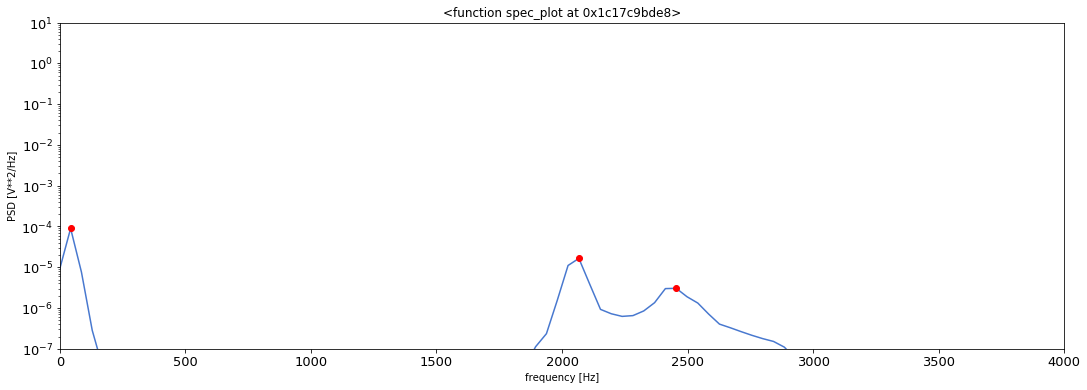

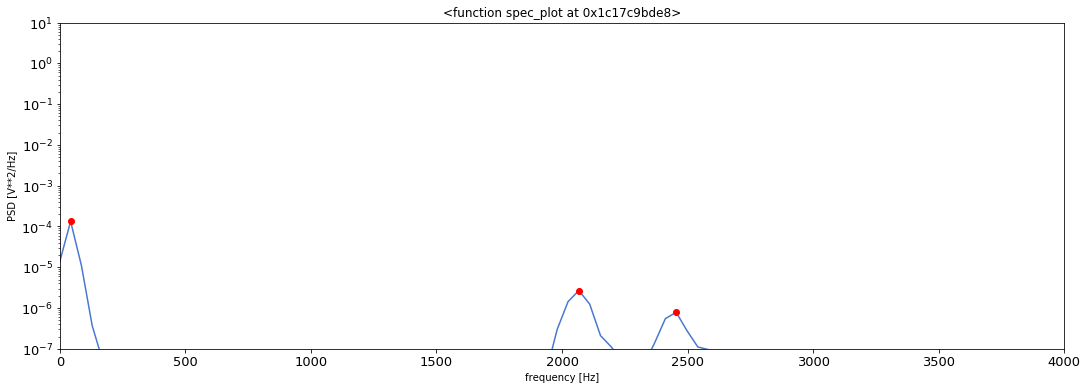

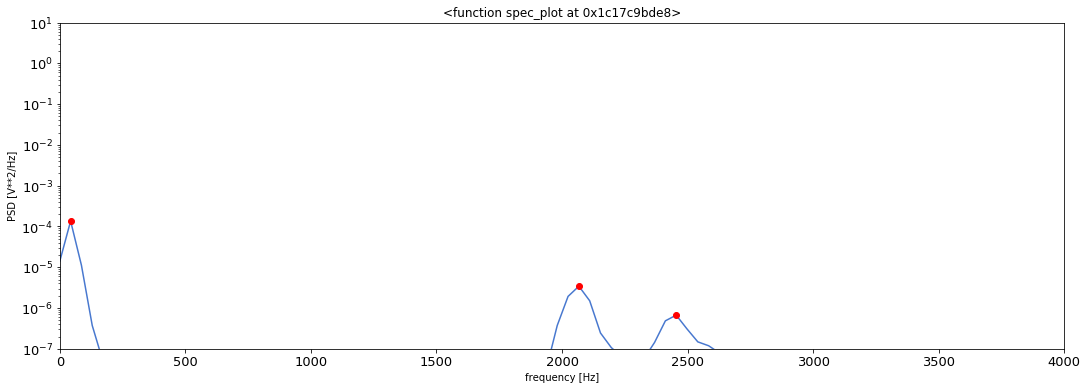

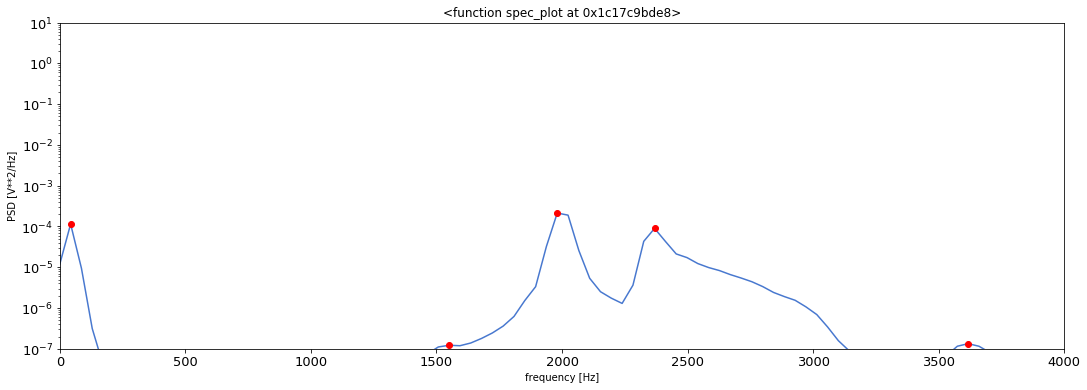

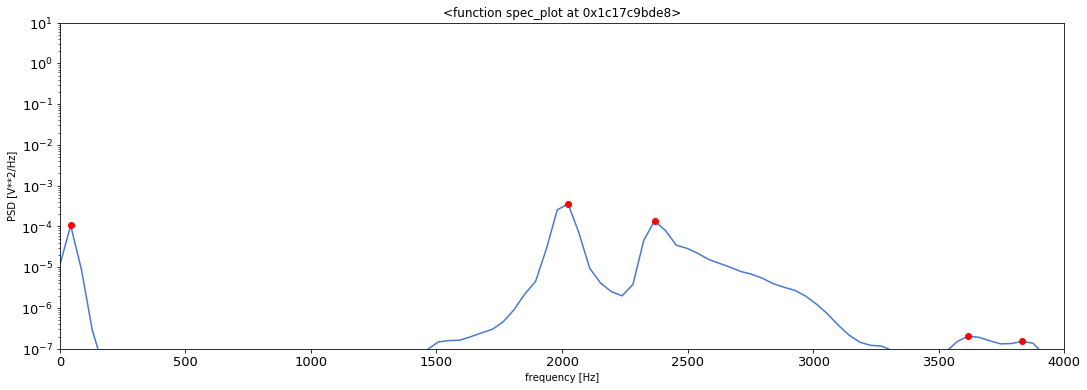

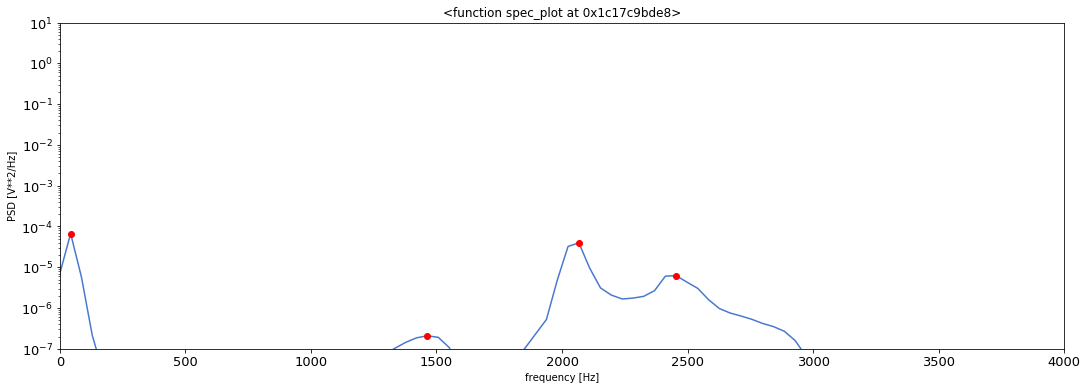

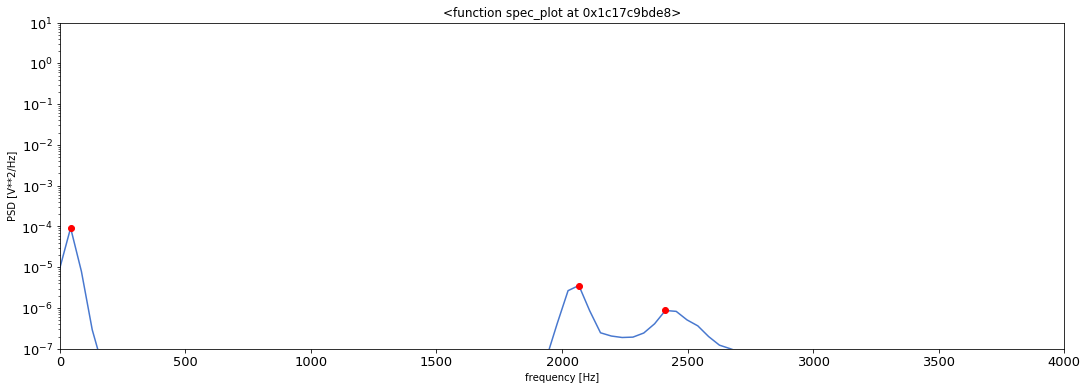

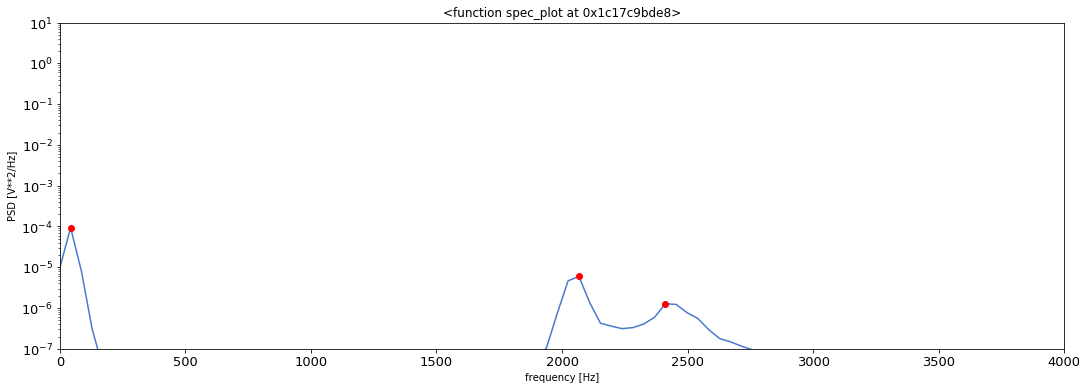

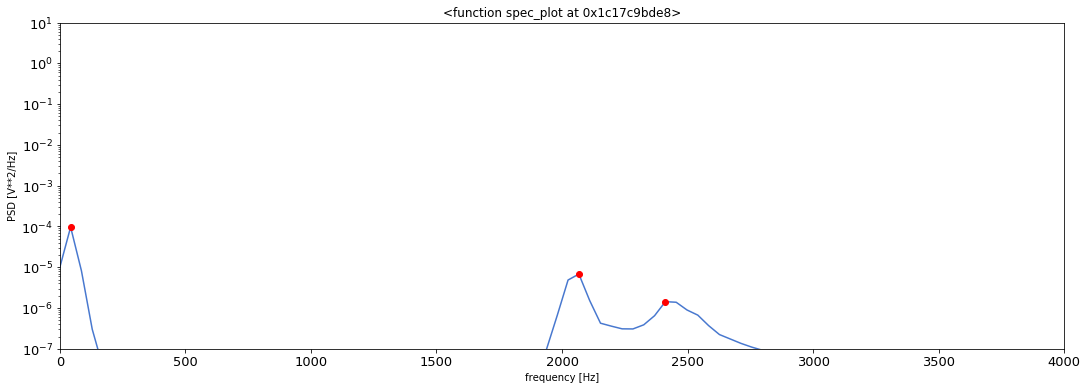

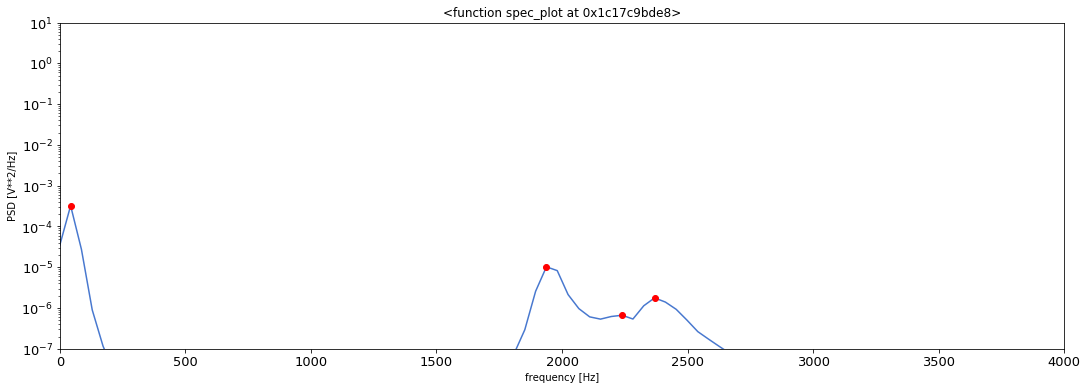

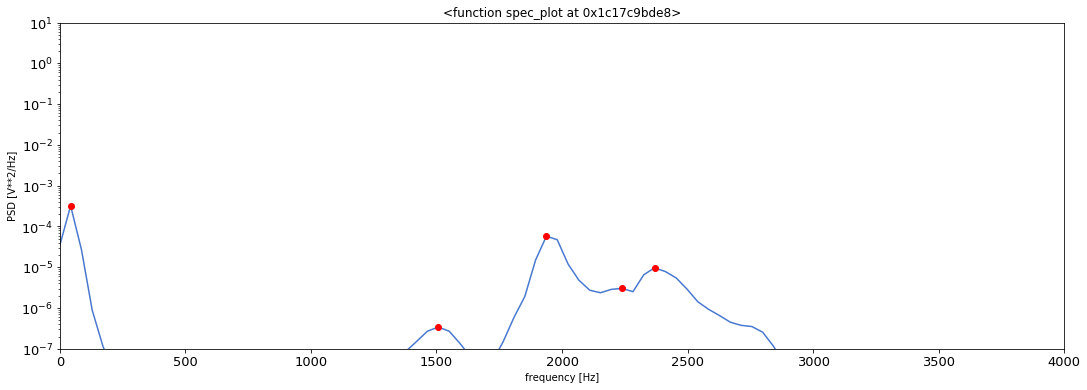

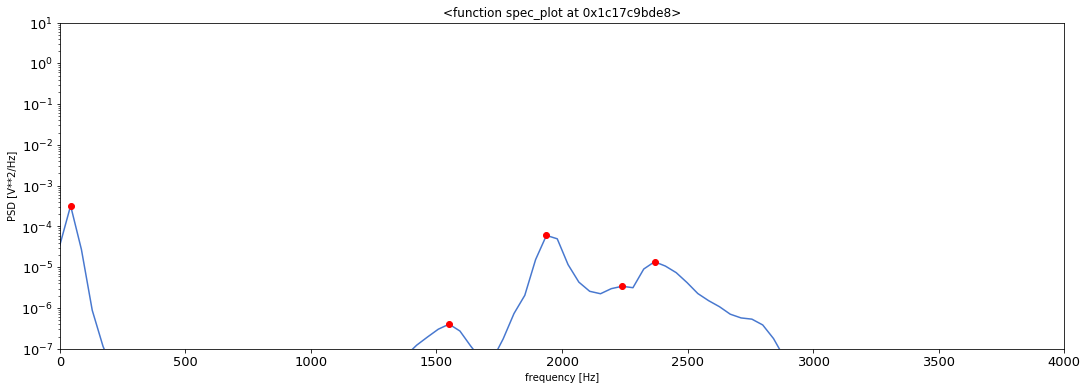

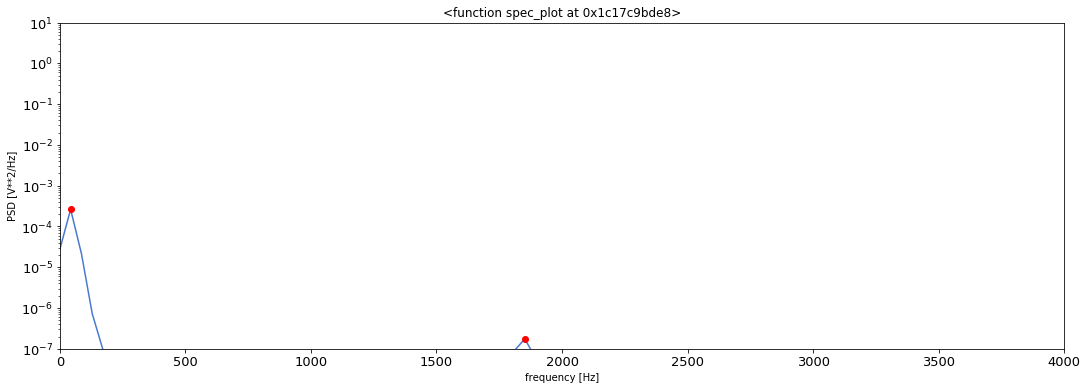

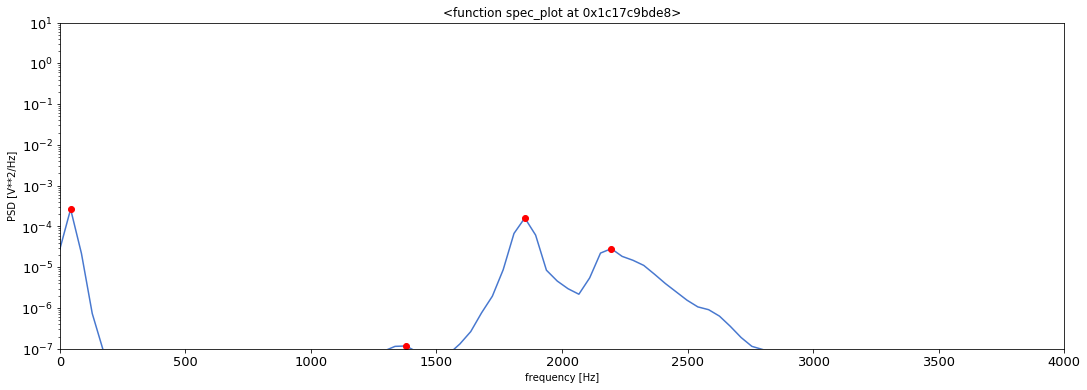

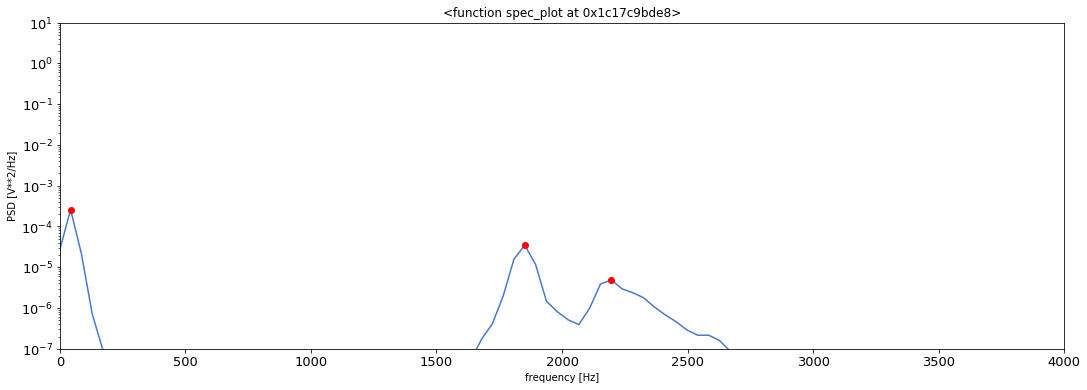

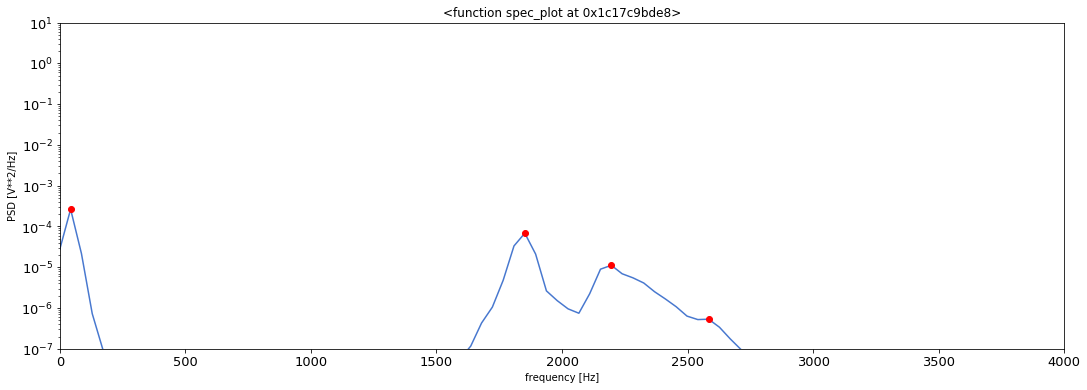

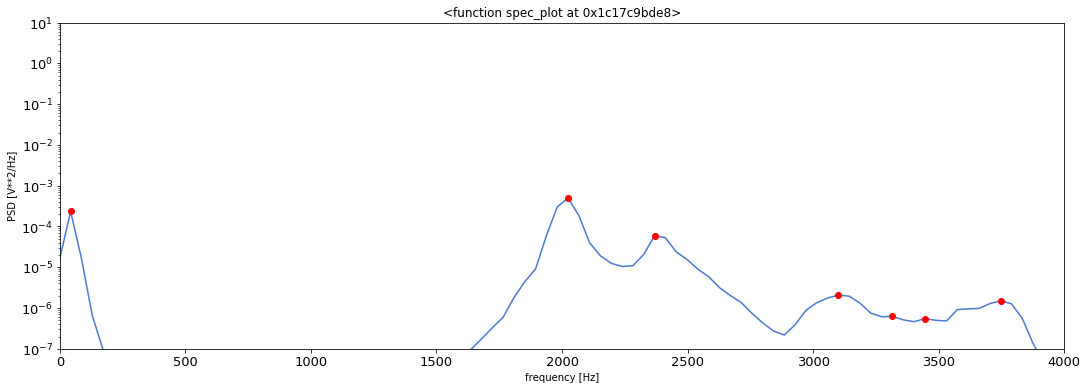

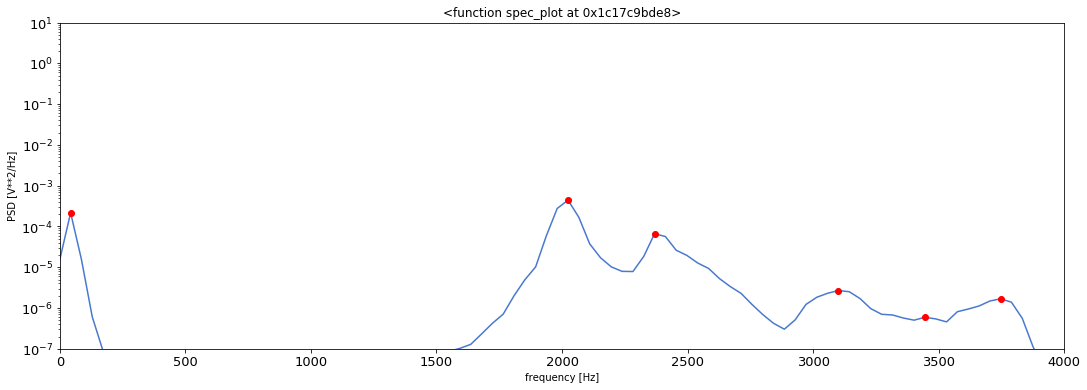

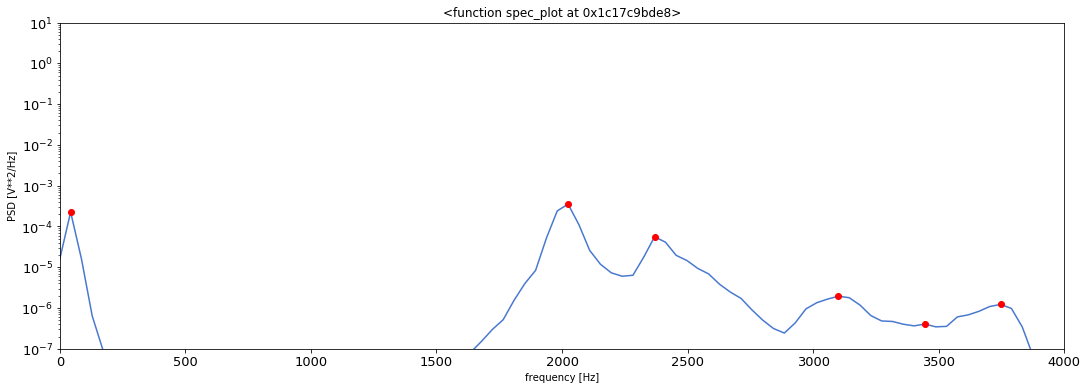

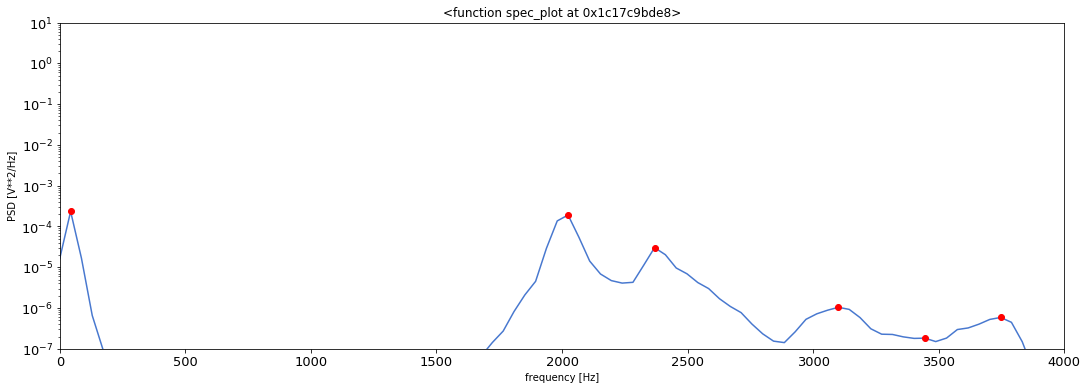

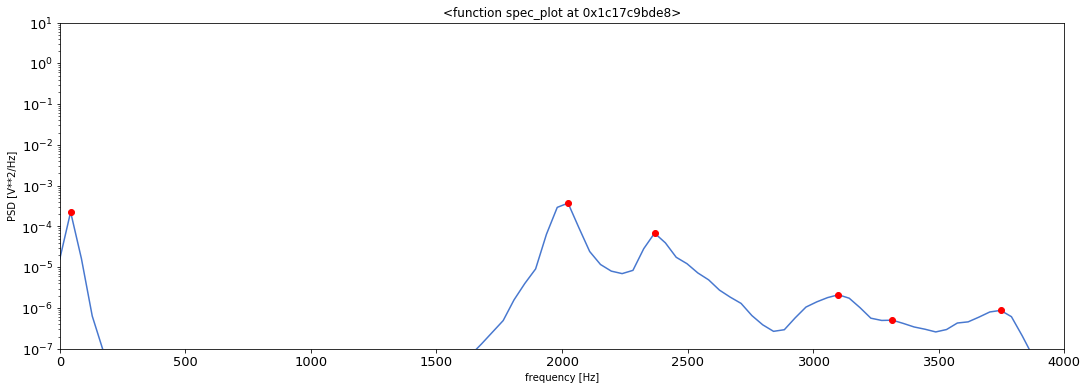

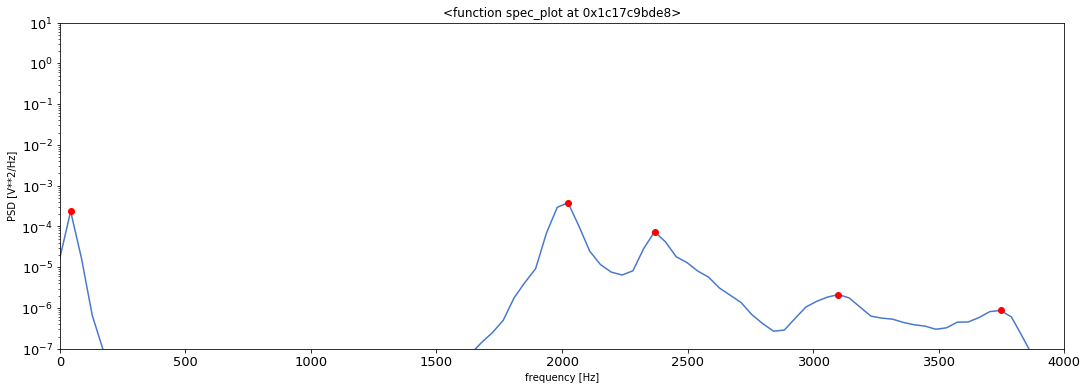

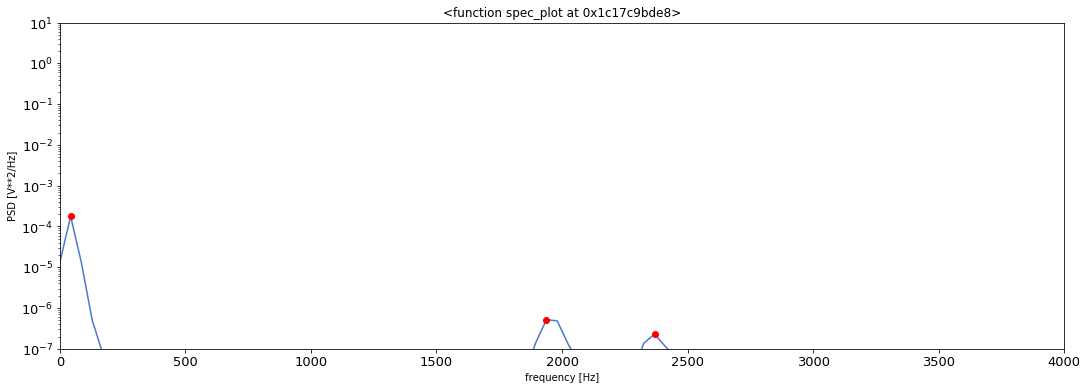

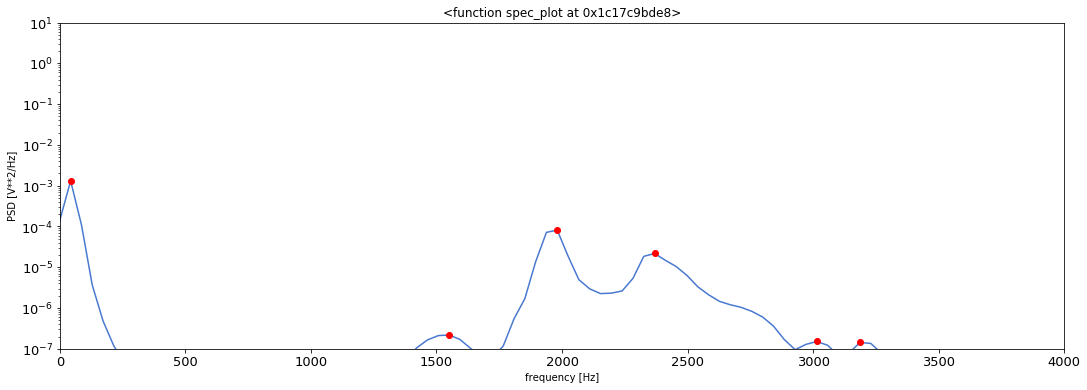

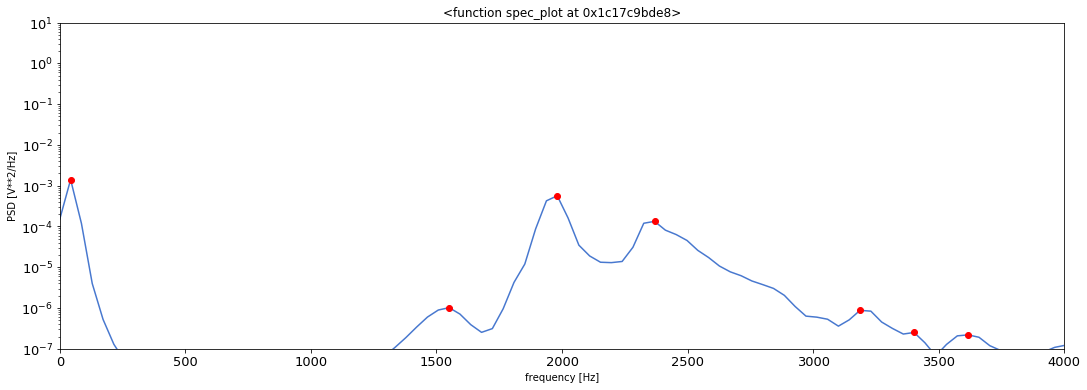

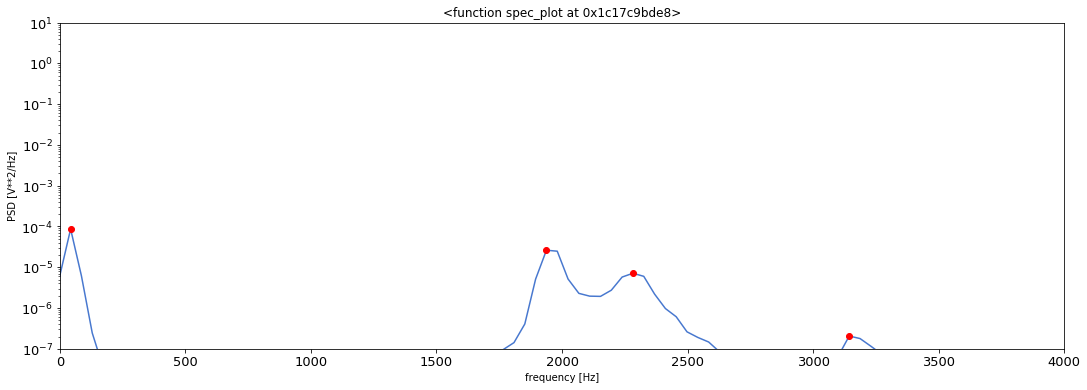

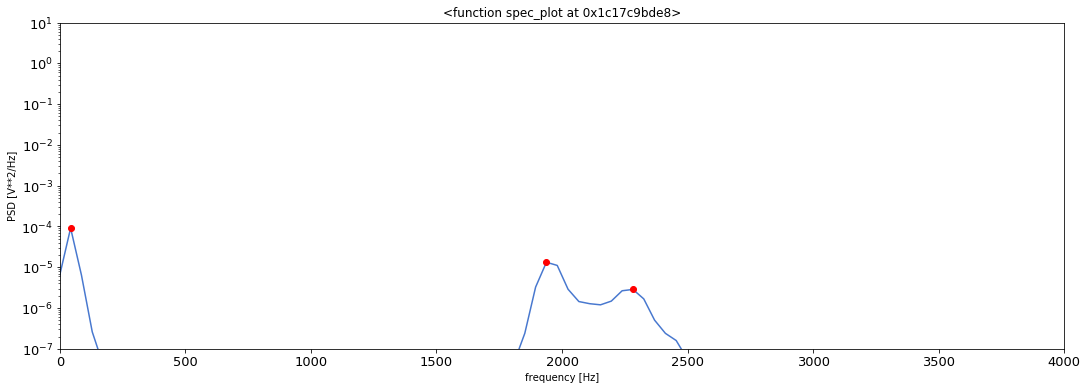

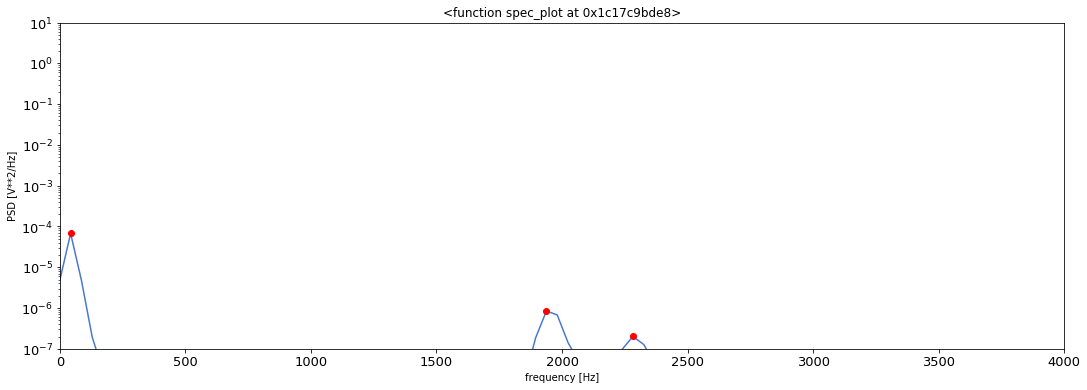

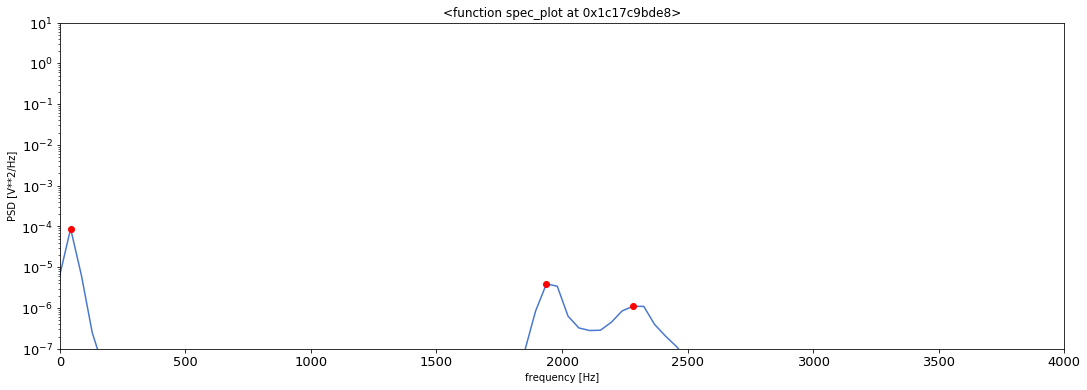

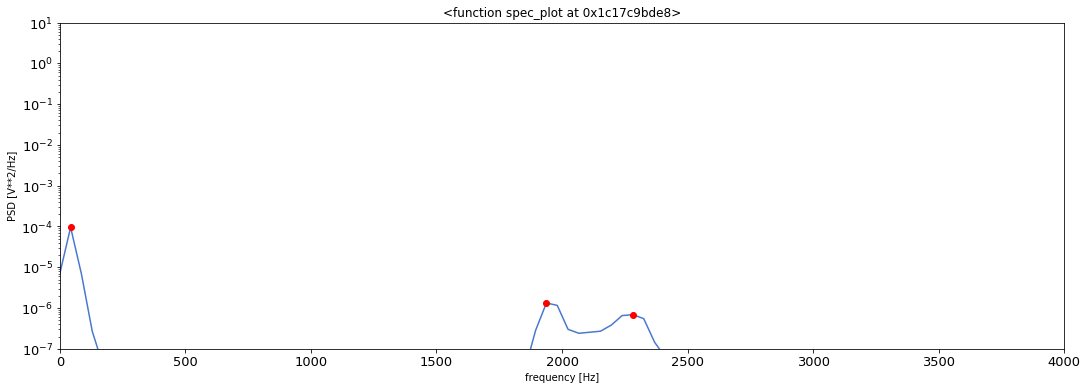

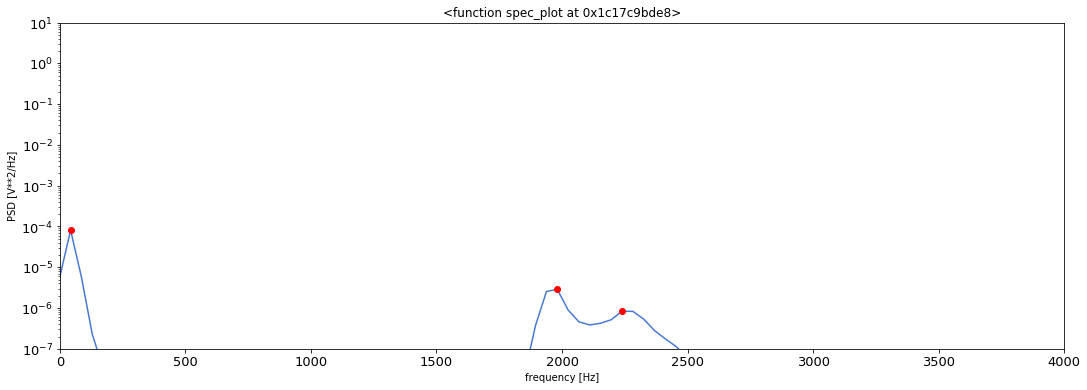

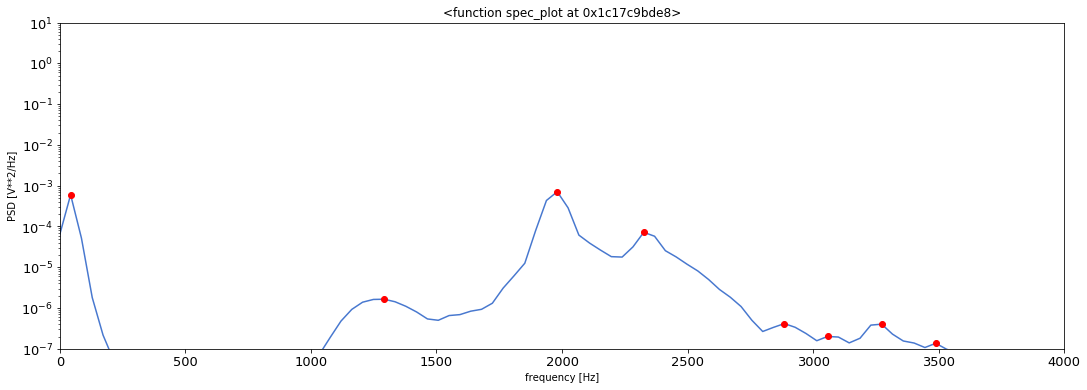

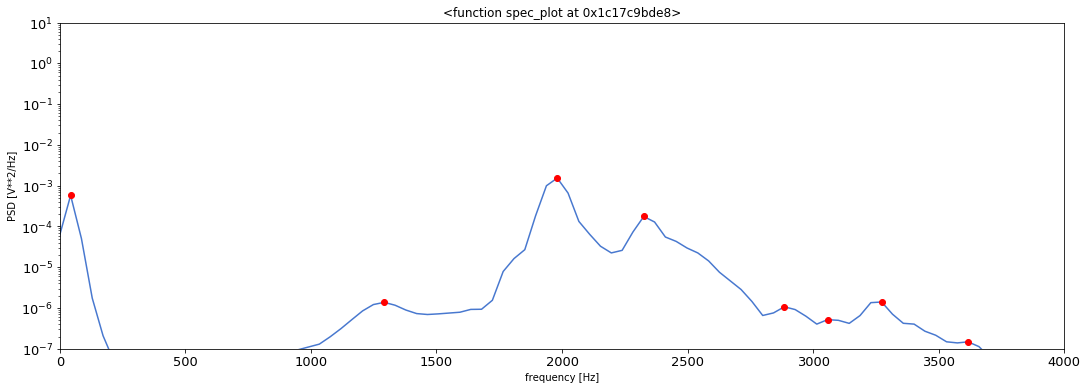

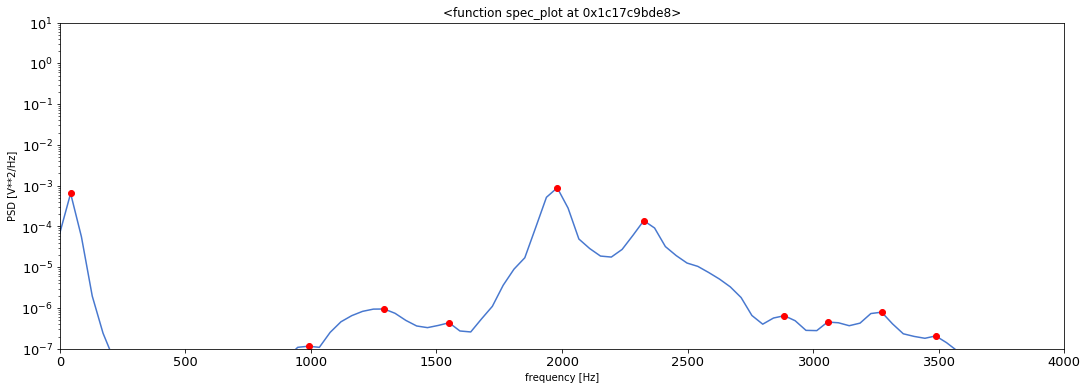

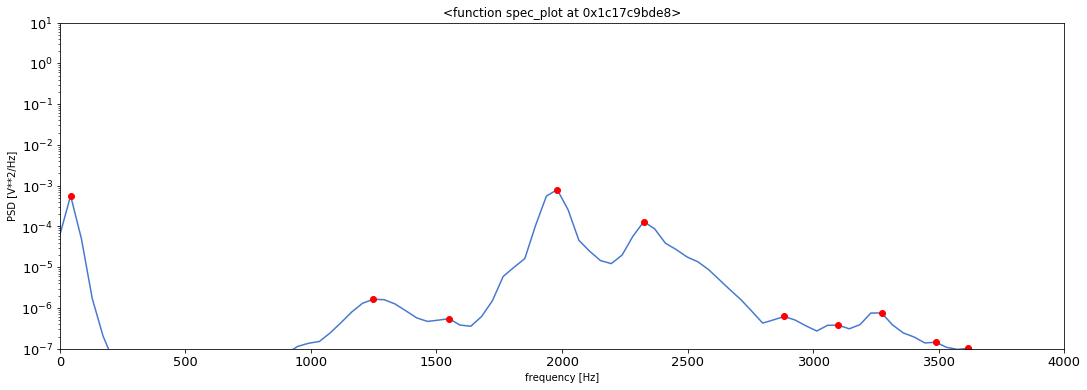

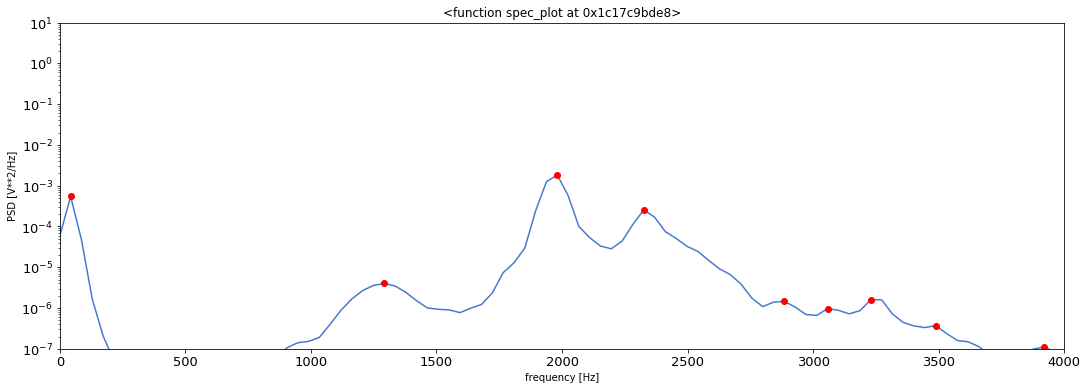

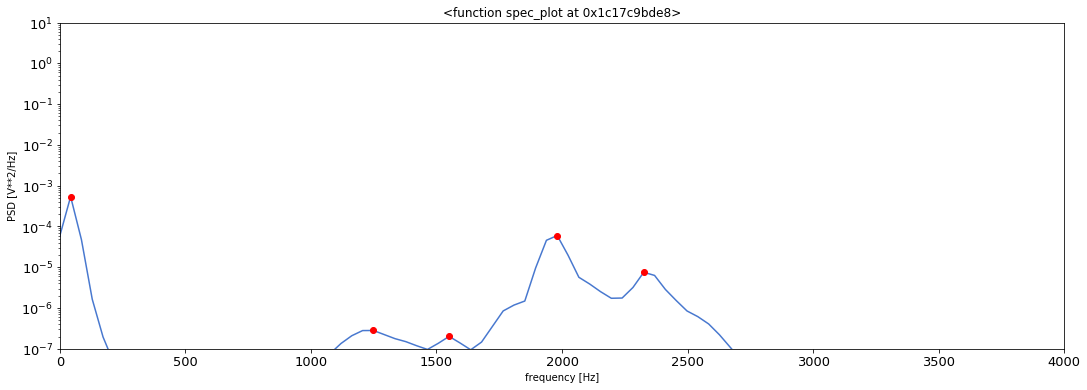

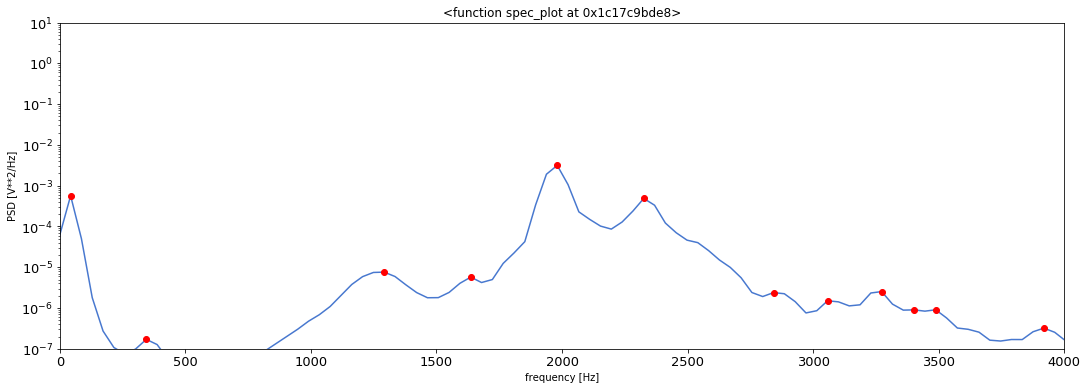

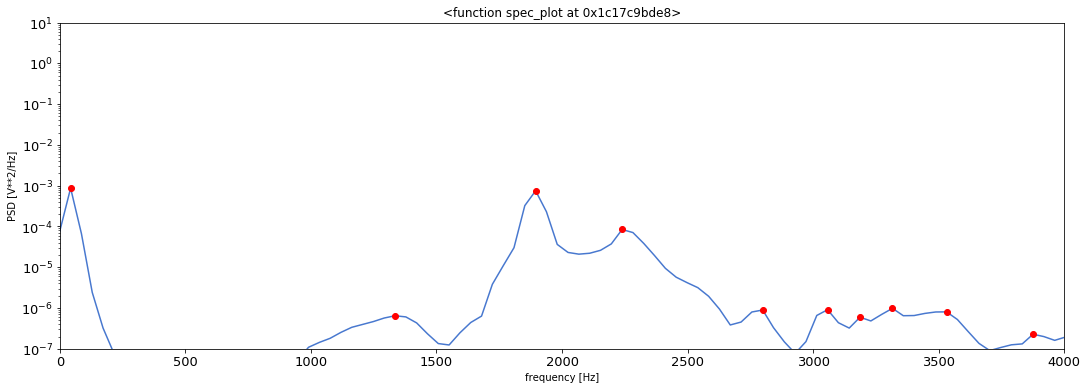

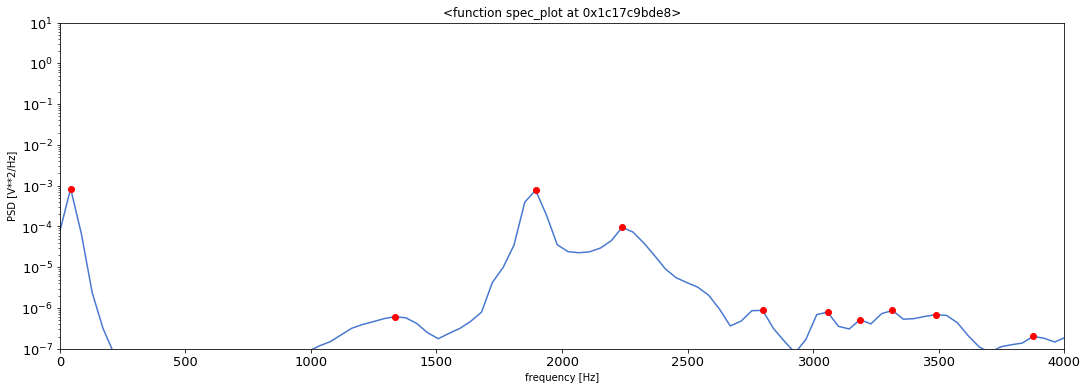

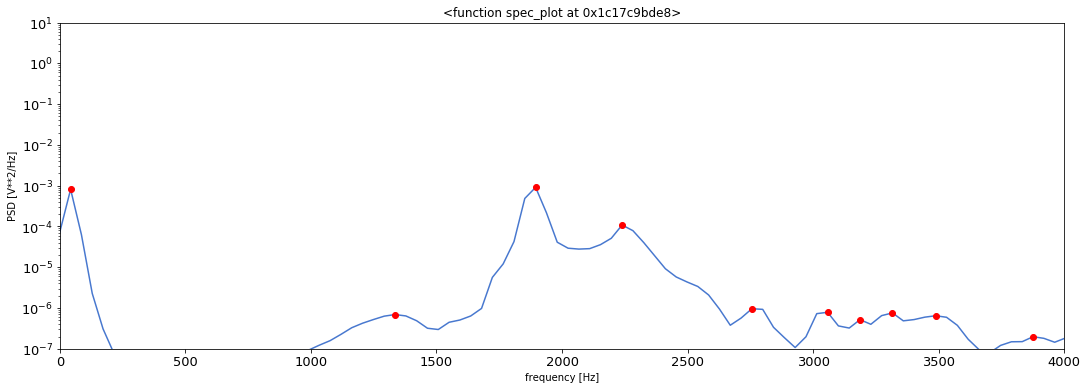

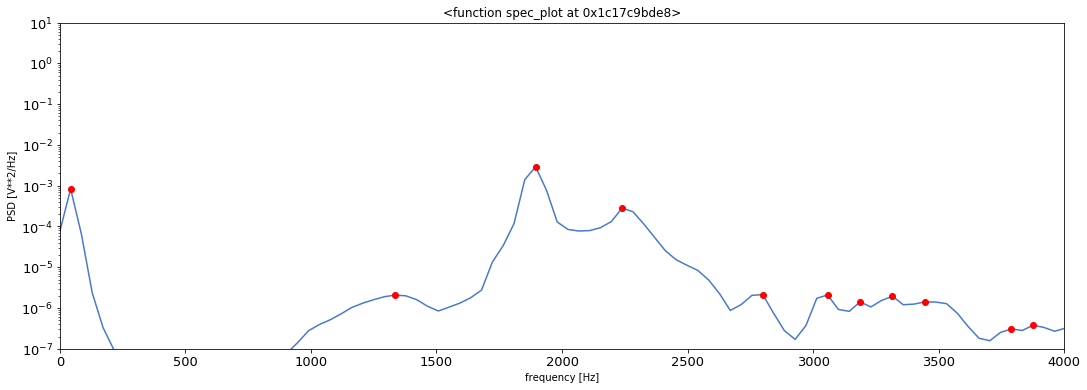

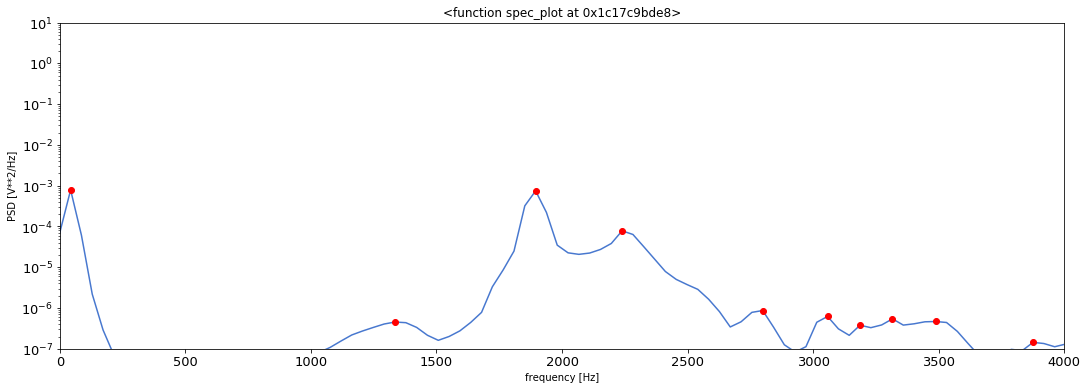

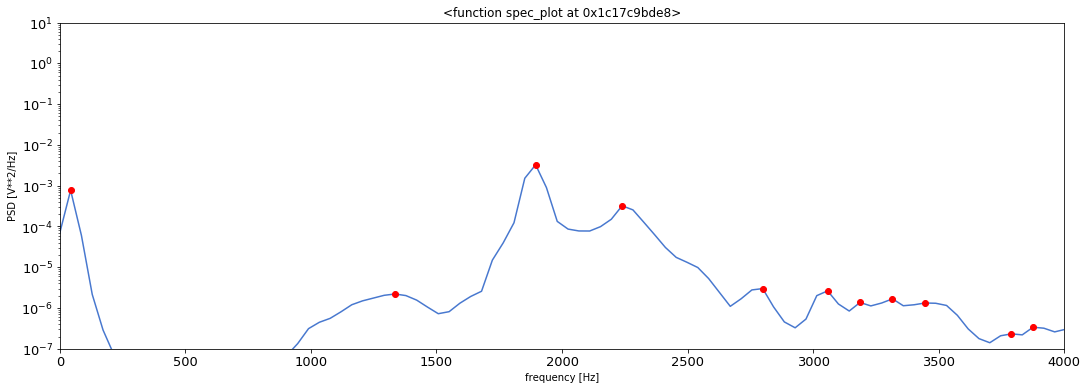

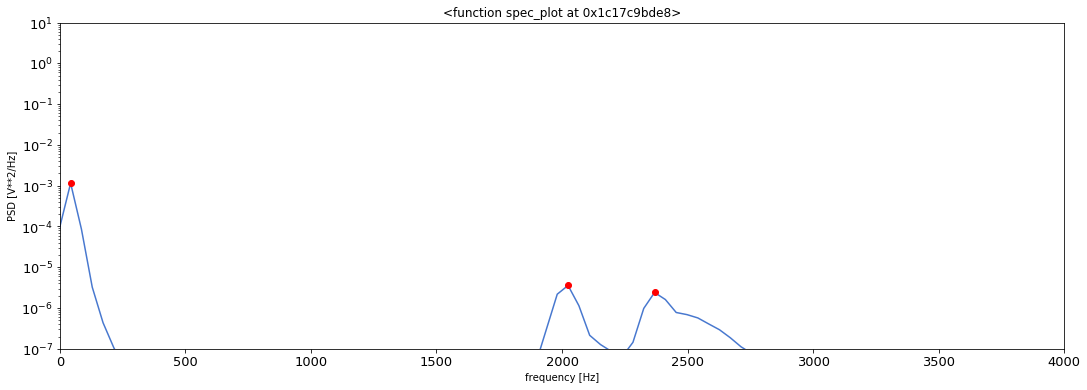

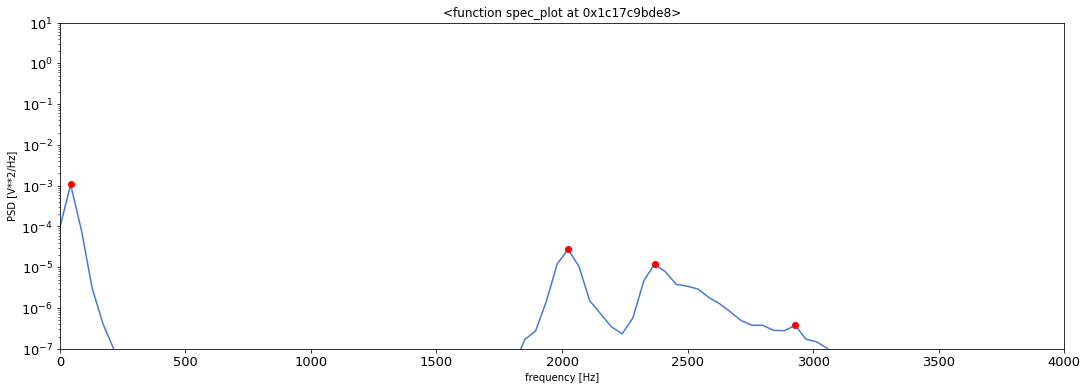

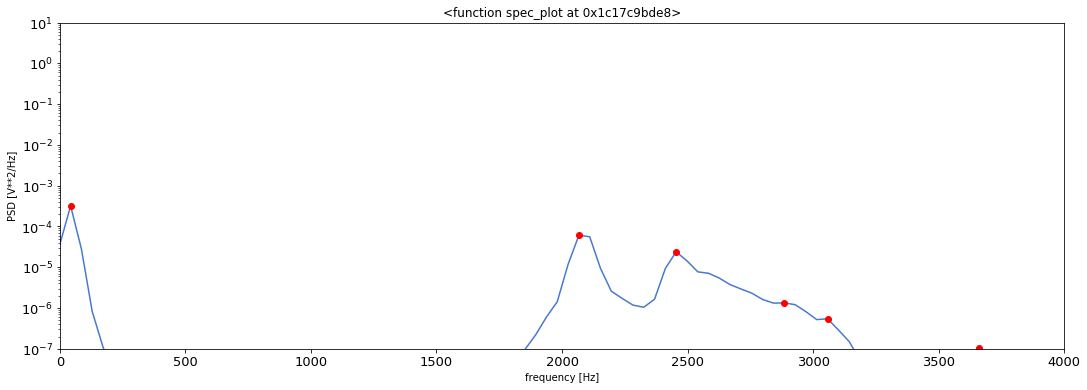

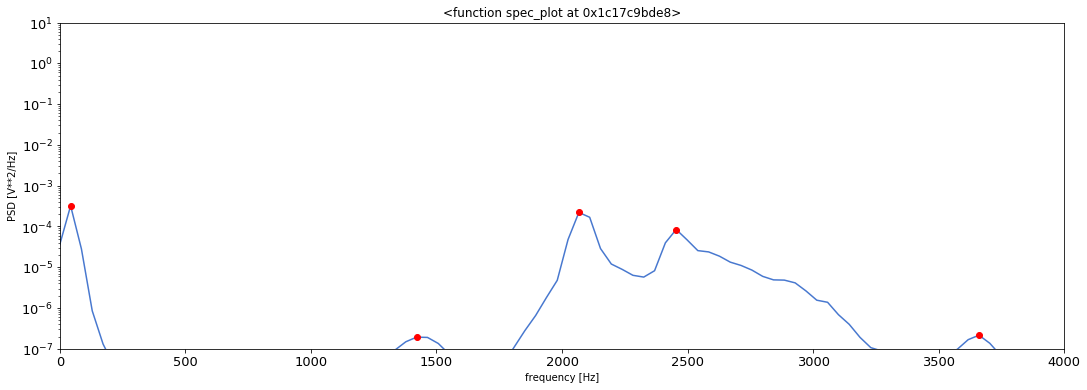

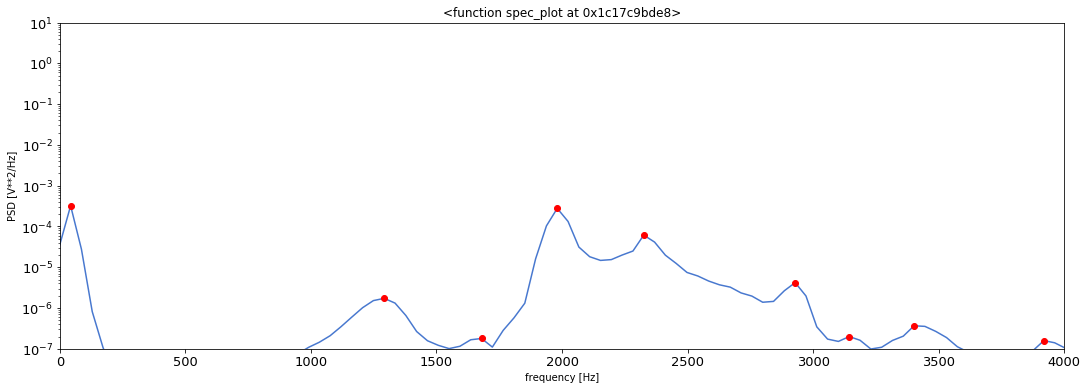

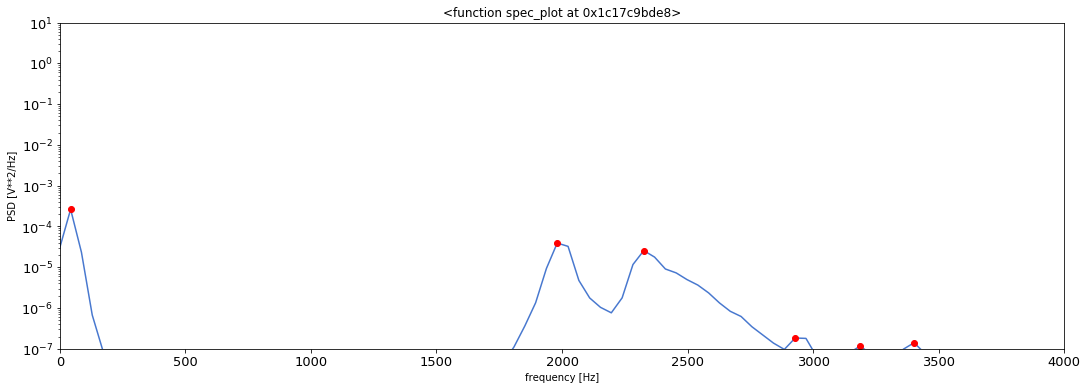

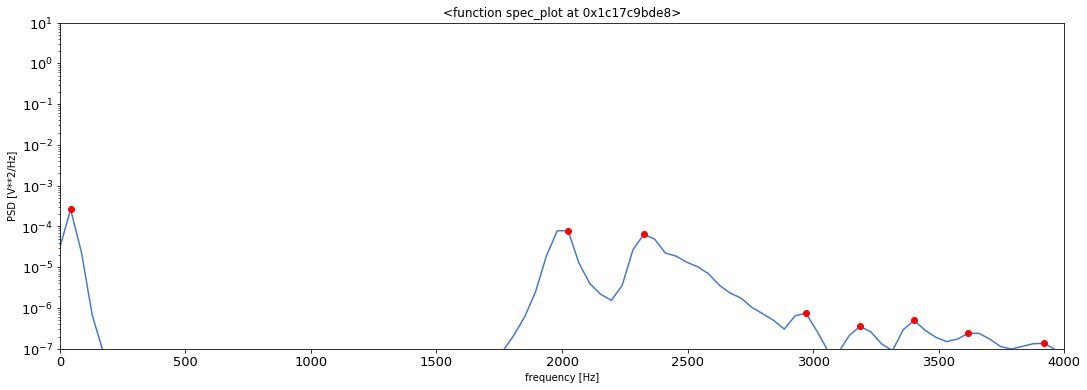

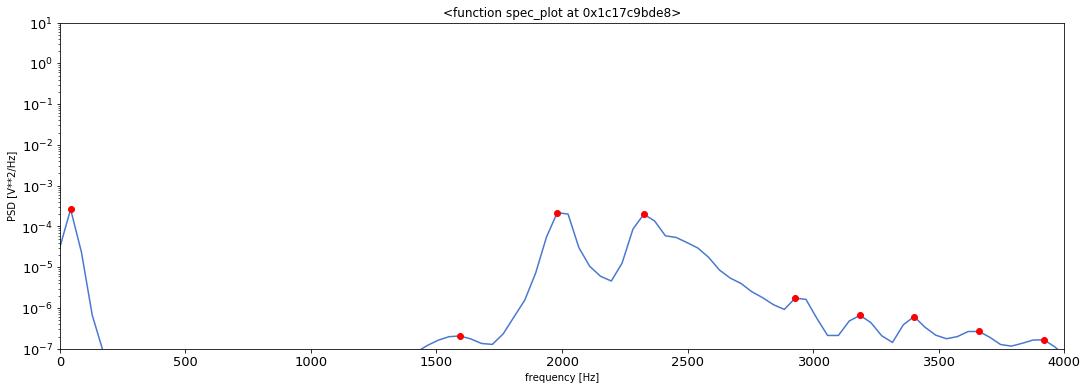

In [89]:
import os
from scipy import signal
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
from multiprocessing import Pool
from functools import partial
import os.path
from os import path

Fs = 44100
maxdur=3600
directory='/Volumes/Kelley_lab/Wave_files/'
outdir=directory
for filename in os.listdir(directory):
#for filename in samples_remaining:
    if filename.endswith(".wav"):
        
        print(filename)
        audio_path=os.path.join(directory, filename)
        specplot_name=os.path.basename(os.path.splitext(audio_path)[0])+"_calls.txt"
        specplot_name1=os.path.basename(os.path.splitext(audio_path)[0])+"_completed1.txt"
        specplot_name2=os.path.basename(os.path.splitext(audio_path)[0])+"_completed2.txt"



        my_file=os.path.join(outdir, specplot_name)
        my_file1=os.path.join(outdir, specplot_name1)
        my_file2=os.path.join(outdir, specplot_name2)




        if path.exists(my_file) or path.exists(my_file1) or path.exists(my_file2):
            print("done")
        else:

            completed_file=os.path.basename(os.path.splitext(audio_path)[0])+"_duration.txt"
            my_file1=os.path.join(outdir, specplot_name)
            
            if path.exists(my_file1):
                print("done")
            
            else:
            
                signal_p, Fs = librosa.load(audio_path, sr = Fs, duration = maxdur) 


                f, Pxx_den = signal.welch(signal_p, Fs, 'hanning', 1024, scaling='spectrum')

                peaks_sp, _ = find_peaks(Pxx_den, prominence = 10e-10, height = 10e-8)

                print(len(peaks_sp))
                if(len(peaks_sp)>1):
                    specplot_name=os.path.basename(os.path.splitext(audio_path)[0])+"_spec.png"
                    plt.figure(figsize=(18, 6))
                    plt.semilogy(f, Pxx_den)
                    plt.ylim([1e-7, 1e1])
                    plt.xlim([0,4000])
                    plt.xlabel('frequency [Hz]')
                    plt.ylabel('PSD [V**2/Hz]')
                    plt.title(spec_plot)
                    plt.plot(f[peaks_sp], Pxx_den[peaks_sp], "ro")
                    plt.savefig(os.path.join(outdir, specplot_name), bbox_inches='tight')
                    

                    peaks_file=os.path.basename(os.path.splitext(audio_path)[0])+"_peaks.txt"
                    np.savetxt(os.path.join(outdir, peaks_file), np.column_stack((f[peaks_sp], Pxx_den[peaks_sp])), fmt='%s')


                    peaks_sp = peaks_sp[np.where((f[peaks_sp]>500) & (f[peaks_sp]<4000))]
                    if (len(peaks_sp)>1):
                        ind = np.argpartition(Pxx_den[peaks_sp], -2)[-2:]
                        peaks_sp=f[peaks_sp][ind]
                    if (len(peaks_sp)==1):
                        peaks_sp=f[peaks_sp]

                    peaks_file=os.path.basename(os.path.splitext(audio_path)[0])+"_fpeaks.txt"
                    np.savetxt(os.path.join(outdir, peaks_file), peaks_sp, fmt='%s')



                    if(len(peaks_sp)>0):


                        lowcut=min(peaks_sp)-50
                        highcut=max(peaks_sp)+50

                        xf = butter_bandpass_filter(signal_p, lowcut, highcut, Fs, order=4)

                        rms = librosa.feature.rms(y=xf)[0]

                        n_peak=0.002
                        r_normalized = (rms - n_peak) / np.std(rms)
                        p = np.exp(r_normalized) / (1 + np.exp(r_normalized))


                        transition = librosa.sequence.transition_loop(2, [0.65, 0.7])
                        times = librosa.frames_to_time(np.arange(len(rms)), sr = Fs)
                        rmsframe=librosa.time_to_samples(times, sr = Fs)

                        full = np.vstack([1 - p, p])
                        states = librosa.sequence.viterbi_discriminative(full, transition)


                        seqint = rle(states, rmsframe)
                        df = pd.DataFrame({'width': seqint[0], 'start': seqint[1], 'end': seqint[2], 'type': seqint[3], 'fstart': seqint[4], 'fend':seqint[5], 'tstart': seqint[6], 'tend':seqint[7]}, columns=['type', 'fstart', 'fend', 'tstart', 'tend', 'start', 'end', 'width'])
                        call_data=df.query('type != 0')

                        dur_file=os.path.basename(os.path.splitext(audio_path)[0])+"_duration.txt"
                        #np.savetxt(os.path.join(outdir, dur_file), seqint, fmt='%s')
                        np.savetxt(os.path.join(outdir, dur_file), df.values, fmt='%d')

                        if(len(call_data)>0):
                            callresults=parallelize_on_rows(call_data, callpulse)
                            flat_list = []
                            for sublist in callresults:
                                if sublist is not None:
                                    if isinstance(sublist, int):
                                        sublist=[sublist]
                                    for item in sublist:
                                        flat_list.append(item)



                            call_result_file=os.path.basename(os.path.splitext(audio_path)[0])+"_calls.txt"
                            np.savetxt(os.path.join(outdir, call_result_file), flat_list, fmt='%s')



                        completed_file=os.path.basename(os.path.splitext(audio_path)[0])+"_completed1.txt"
                        np.savetxt(os.path.join(outdir, completed_file), np.array([2,3,1,0]), fmt='%s')

                else:
                    completed_file=os.path.basename(os.path.splitext(audio_path)[0])+"_completed1.txt"
                    np.savetxt(os.path.join(outdir, completed_file), np.array([2,3,1,0]), fmt='%s')
